<h1>국내 여행 로그 데이터(서부권) (2023)</h1>
<h2>[데이터 정보]</h2>
<ul>
<li>2023 12,800명 이상의 데이터 구축</li>
<li>Metadata 관련 파일 : 시군구코드.csv, 코드A.csv, 코드B.csv (분석 참고용) </li>
<li>분석용 데이터 : 여행객.csv, 동반자정보.csv, 여행.csv, 이동내역.csv, GPS좌표.csv, 이동수단소비내역.csv, 숙박소비내역.csv, 활동내역.csv, 사전소비내역.csv, 활동소비내역.csv, 방문지정보.csv, 관광사진.csv
<br> > 참고 : 가독성을 위해 원본 데이터의 파일명(CSV명)을 일부 수정하였고, 분석에 필요하지 않다고 판단한 GPS좌표.csv, 관광사진.csv, 이동내역.csv, 방문지정보.csv는 제외하고 분석을 진행</li>
<li> Metadata 관련 파일 설명
<br> 1. 시군구코드.csv
 <br>- 시도코드(2자리), 시군구코드(3자리), 읍면동코드(3자리)를 포함
 <br>- 시군구코드가 필요한 분석 결과는 해당 CSV 파일을 참고
<br> 2. 코드B.csv
 <br>- 분석용 데이터에서 숫자값으로 입력된 코드들의 실제 한글값을 제공
 <br>- 해당 분석에서는 시각화 시 가독성을 위해 코드B.csv의 값들을 이용하여 숫자값을 한글값으로 변환하여 사용</li></ul>
<h2>[분석 정보]</h2>
<ul>
<li>원본 데이터 손상 방지를 위해 모든 데이터는 복사본을 만들어서 분석 진행
<br> > 예시 : 원본 데이터 프레임이 raw_traveller_master 라면, 분석을 진행하는 데이터 프레임은 traveller_master로 설정</li>
<li>각 CSV 파일에서 분석에 필요한 변수들은 사전 작업을 통해 선별함
<br>의미 및 순위가 불확실한 변수들도 제외</li>
<li>여행객.csv를 제외한 모든 CSV 파일에는 TRAVEL_ID가존재하며, 여행객.csv의 TRAVELER_ID도 TRAVEL_ID의 형식으로 변환 가능하므로, TRAVEL_ID를 기준으로 각 데이터를 통합함</li></ul>



<hr>
<h2>[패키지 및 데이터 로드]</h2>

In [2149]:
# 데이터를 분석하는데 필요한 패키지 로드하기 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
plt.rcParams.update({'font.family' : 'Malgun Gothic'}) 

# 숫자 표기 설정
pd.options.display.float_format = '{:,.2f}'.format # 지수 없이 숫자로
#pd.reset_option('display.float_format') # 지수표기법

# 출력 설정 변경 (None : 모든 행,열 출력)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
#pd.reset_option('all') # 설정 변경 초기화 

In [2150]:
# 분석용 데이터 불러오기
raw_traveller_master = pd.read_csv('data/training/original_data/여행객.csv', encoding='UTF-8')
raw_companion_info = pd.read_csv('data/training/original_data/동반자정보.csv', encoding='UTF-8')
raw_travel = pd.read_csv('data/training/original_data/여행.csv', encoding='UTF-8')
raw_mvmn_consume = pd.read_csv('data/training/original_data/이동수단소비내역.csv', encoding='UTF-8')
raw_lodge_consume = pd.read_csv('data/training/original_data/숙박소비내역.csv', encoding='UTF-8')
raw_activity = pd.read_csv('data/training/original_data/활동내역.csv', encoding='UTF-8')
raw_activity_consume = pd.read_csv('data/training/original_data/활동소비내역.csv', encoding='UTF-8')
raw_adv_consume = pd.read_csv('data/training/original_data/사전소비내역.csv', encoding='UTF-8')

# 복사본 만들기 
traveller_master = raw_traveller_master.copy()
companion_info = raw_companion_info.copy()
travel = raw_travel.copy()
mvmn_consume = raw_mvmn_consume.copy()
lodge_consume = raw_lodge_consume.copy()
activity = raw_activity.copy()
activity_consume = raw_activity_consume.copy()
adv_consume = raw_adv_consume.copy()

<hr>
<h2>[한글값 매핑]</h2>

In [2151]:
# 코드 'ACT'
ACT_mapping = {
    1 : '취식',
    2 : '쇼핑 / 구매',
    3 : '체험 활동 / 입장 및 관람',
    4 : '단순 구경 / 산책 / 걷기',
    5 : '휴식',
    6 : '기타 활동',
    7 : '환승/경유',
    99 : '없음'
}

# 코드 'AGE'
AGE_mapping = {
    1 : '~9세이하',
    2 : '10대',
    3 : '20대',
    4 : '30대',
    5 : '40대',
    6 : '50대',
    7 : '60대',
    8 : '70세이상'
}

# 코드 'GEN'
GEN_mapping = {
    1 : '남자',
    2 : '여자'
}

# 코드 'HTY'
HTY_mapping = {
    1 : '호텔',
    2 : '모텔/여관',
    3 : '펜션',
    4 : '콘도미니엄/리조트',
    5 : '야영(캠핑,글램핑등)',
    6 : '전통 숙박시설',
    7 : '게스트하우스',
    8 : '민박',
    9 : '자연휴양림내 시설',
    10 : '가족/친지집',
    11 : '기타',
    12 : '무박 여행'
}

# 코드 'JOB'
JOB_mapping = {
    1 : '관리자',
    2 : '전문가 및 관련 종사자',
    3 : '사무 종사자',
    4 : '서비스 종사자',
    5 : '판매 종사자',
    6 : '농림어업 숙련 종사자',
    7 : '기능원 및 관련 기능 종사자',
    8 : '장치․기계 조작 및 조립 종사자',
    9 : '단순노무종사자',
    10 : '군인',
    11 : '전업주부',
    12 : '학생',
    13 : '기타'
}

# 코드 'MIS'
MIS_mapping = {
    1 : '쇼핑',
    2 : '테마파크, 놀이시설, 동/식물원 방문',
    3 : '역사 유적지 방문',
    4 : '시티투어',
    5 : '야외 스포츠, 레포츠 활동',
    6 : '지역 문화예술/공연/전시시설 관람',
    7 : '유흥/오락(나이트라이프)',
    8 : '캠핑',
    9 : '지역 축제/이벤트 참가',
    10 : '온천/스파',
    11 : '교육/체험 프로그램 참가',
    12 : '드라마 촬영지 방문',
    13 : '종교/성지 순례',
    21 : 'Well-ness 여행',
    22 : 'SNS 인생샷 여행',
    23 : '호캉스 여행',
    24 : '신규 여행지 발굴',
    25 : '반려동물 동반 여행',
    26 : '인플루언서 따라하기 여행',
    27 : '친환경 여행(플로깅 여행)',
    28 : '등반 여행'
}

# 코드 'TCR'
TCR_mapping = {
    1 : '배우자',
    2 : '자녀',
    3 : '부모',
    4 : '조부모',
    5 : '형제/자매',
    6 : '친인척',
    7 : '친구',
    8 : '연인',
    9 : '동료',
    10 : '친목 단체/모임(동호회, 종교단체 등)',
    11 : '기타'
}

# 코드 'TMT'
TMT_mapping = {
    1 : '일상적인 환경 및 역할에서의 탈출, 지루함 탈피',
    2 : '쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식',
    3 : '여행 동반자와의 친밀감 및 유대감 증진',
    4 : '진정한 자아 찾기 또는 자신을 되돌아볼 기회 찾기',
    5 : 'SNS 사진 등록 등 과시',
    6 : '운동, 건강 증진 및 충전',
    7 : '새로운 경험 추구',
    8 : '역사 탐방, 문화적 경험 등 교육적 동기',
    9 : '특별한 목적(칠순여행, 신혼여행, 수학여행, 인센티브여행)',
    10 : '기타'
}

# 코드 'TSY' (자연 VS 도시)
TSY_mapping = {
    1 : '자연 선호(강)',
    2 : '자연 선호(중)',
    3 : '자연 선호(약)',
    4 : '중립',
    5 : '도시 선호(약)',
    6 : '도시 선호(중)',
    7 : '도시 선호(강)'
}

# 코드 'TTM'
TTM_mapping = {
    1 : '1주일',
    2 : '한달',
    3 : '1년',
    4 : '기타'
}

In [2152]:
# 데이터프레임 변환 함수
def convert_codes_to_korean(df, column_name, mapping) : 
    if column_name in df.columns : 
        df[column_name] = df[column_name].astype('int64')
        df[column_name] = df[column_name].map(mapping)
    return df

<hr>
<h2>[여행객.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2153]:
# 필요한 변수 리스트
columns_to_keep_traveller = [
    'TRAVELER_ID', 'GENDER', 'AGE_GRP', 'JOB_NM', 'TRAVEL_TERM', 'TRAVEL_LIKE_SGG_1', 'TRAVEL_LIKE_SGG_2', 'TRAVEL_LIKE_SGG_3', 
    'TRAVEL_STYL_1','TRAVEL_STYL_2','TRAVEL_STYL_3','TRAVEL_STYL_4','TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8',
    'TRAVEL_STATUS_RESIDENCE', 'TRAVEL_STATUS_DESTINATION', 'TRAVEL_STATUS_ACCOMPANY', 'TRAVEL_MOTIVE_1', 'TRAVEL_COMPANIONS_NUM'
    ]

# traveller_master에 필요한 변수만 남기고 저장
traveller_master = traveller_master[columns_to_keep_traveller]

# 변수명 변경
traveller_master = traveller_master.rename(columns={'TRAVEL_MOTIVE_1' : 'TRAVEL_MOTIVE'})

# 결과 확인
print(traveller_master.head())

  TRAVELER_ID GENDER  AGE_GRP  JOB_NM  TRAVEL_TERM  TRAVEL_LIKE_SGG_1  TRAVEL_LIKE_SGG_2  TRAVEL_LIKE_SGG_3  TRAVEL_STYL_1  TRAVEL_STYL_2  TRAVEL_STYL_3  TRAVEL_STYL_4  TRAVEL_STYL_5  TRAVEL_STYL_6  TRAVEL_STYL_7  TRAVEL_STYL_8 TRAVEL_STATUS_RESIDENCE TRAVEL_STATUS_DESTINATION TRAVEL_STATUS_ACCOMPANY  TRAVEL_MOTIVE  TRAVEL_COMPANIONS_NUM
0     g002178      여       20      12            3              50130              50110              26500              1              1              1              3              3              2              6              6                   광주광역시                        전남             2인 여행(가족 외)              1                      1
1     g004485      남       40       2            2              48840              48220              26500              1              1              3              6              4              2              7              7                   대전광역시                        전북             2인 여행(가족 외)              1    

In [2154]:
# 데이터의 행, 열 개수 출력
print('여행객.csv의 행, 열 개수 : ')
print(traveller_master.shape)

여행객.csv의 행, 열 개수 : 
(2560, 21)


In [2155]:
# 데이터의 구조와 타입 확인
print('여행객.csv의 구조와 타입 : ')
print(traveller_master.info())

여행객.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   TRAVELER_ID                2560 non-null   object
 1   GENDER                     2560 non-null   object
 2   AGE_GRP                    2560 non-null   int64 
 3   JOB_NM                     2560 non-null   int64 
 4   TRAVEL_TERM                2560 non-null   int64 
 5   TRAVEL_LIKE_SGG_1          2560 non-null   int64 
 6   TRAVEL_LIKE_SGG_2          2560 non-null   int64 
 7   TRAVEL_LIKE_SGG_3          2560 non-null   int64 
 8   TRAVEL_STYL_1              2560 non-null   int64 
 9   TRAVEL_STYL_2              2560 non-null   int64 
 10  TRAVEL_STYL_3              2560 non-null   int64 
 11  TRAVEL_STYL_4              2560 non-null   int64 
 12  TRAVEL_STYL_5              2560 non-null   int64 
 13  TRAVEL_STYL_6              2560 non-null   i

In [2156]:
# 데이터의 결측치 확인
print('여행객.csv의 결측치 : ')
print(traveller_master.isnull().sum())

여행객.csv의 결측치 : 
TRAVELER_ID                  0
GENDER                       0
AGE_GRP                      0
JOB_NM                       0
TRAVEL_TERM                  0
TRAVEL_LIKE_SGG_1            0
TRAVEL_LIKE_SGG_2            0
TRAVEL_LIKE_SGG_3            0
TRAVEL_STYL_1                0
TRAVEL_STYL_2                0
TRAVEL_STYL_3                0
TRAVEL_STYL_4                0
TRAVEL_STYL_5                0
TRAVEL_STYL_6                0
TRAVEL_STYL_7                0
TRAVEL_STYL_8                0
TRAVEL_STATUS_RESIDENCE      0
TRAVEL_STATUS_DESTINATION    0
TRAVEL_STATUS_ACCOMPANY      0
TRAVEL_MOTIVE                0
TRAVEL_COMPANIONS_NUM        0
dtype: int64


In [2157]:
# 데이터 살펴보기
traveller_master.head()

,TRAVELER_ID,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM
0,g002178,여,20,12,3,50130,50110,26500,1,1,1,3,3,2,6,6,광주광역시,전남,2인 여행(가족 외),1,1
1,g004485,남,40,2,2,48840,48220,26500,1,1,3,6,4,2,7,7,대전광역시,전북,2인 여행(가족 외),1,1
2,g005167,남,20,1,3,46710,45190,47170,2,3,1,4,6,3,1,7,서울특별시,전남,2인 여행(가족 외),7,1
3,g002887,여,30,3,2,42150,42210,28710,2,2,3,2,3,5,2,6,인천광역시,대전,2인 여행(가족 외),2,1
4,g004189,남,20,4,2,42150,50110,26350,2,1,2,4,6,5,6,5,경기도,충남,2인 여행(가족 외),2,1


<h3>2. 전처리</h3>

<h5>1) 모든 CSV 파일 통합을 위해 TRAVELER_ID를 TRAVEL_ID 형식으로 변환</h5>

In [2158]:
# TRAVELER_ID의 가장 앞의 알파벳과 _를 추출하여 TRAVELER_ID에 결합하기 위한 함수
def modify_travel_id(travel_id):
    match = re.match(r'([a-zA-Z])(\d+)', travel_id)
    if match:
        return f'{match.group(1)}_{match.group(0)}'
    return travel_id

# TRAVELER_ID 변환
traveller_master['TRAVEL_ID'] = traveller_master['TRAVELER_ID'].apply(modify_travel_id)

# 변환 결과 확인
traveller_master[['TRAVELER_ID', 'TRAVEL_ID']].head()

,TRAVELER_ID,TRAVEL_ID
0,g002178,g_g002178
1,g004485,g_g004485
2,g005167,g_g005167
3,g002887,g_g002887
4,g004189,g_g004189


In [2159]:
# TRAVELER_ID 컬럼 삭제
traveller_master.drop(columns=['TRAVELER_ID'], inplace=True)

# 결과 확인
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,12,3,50130,50110,26500,1,1,1,3,3,2,6,6,광주광역시,전남,2인 여행(가족 외),1,1,g_g002178
1,남,40,2,2,48840,48220,26500,1,1,3,6,4,2,7,7,대전광역시,전북,2인 여행(가족 외),1,1,g_g004485
2,남,20,1,3,46710,45190,47170,2,3,1,4,6,3,1,7,서울특별시,전남,2인 여행(가족 외),7,1,g_g005167
3,여,30,3,2,42150,42210,28710,2,2,3,2,3,5,2,6,인천광역시,대전,2인 여행(가족 외),2,1,g_g002887
4,남,20,4,2,42150,50110,26350,2,1,2,4,6,5,6,5,경기도,충남,2인 여행(가족 외),2,1,g_g004189


<h5>2) JOB_NM 변수 코드 'JOB' 매핑</h5>

In [2160]:
traveller_master = convert_codes_to_korean(traveller_master, 'JOB_NM', JOB_mapping)

# 결과 확인
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,학생,3,50130,50110,26500,1,1,1,3,3,2,6,6,광주광역시,전남,2인 여행(가족 외),1,1,g_g002178
1,남,40,전문가 및 관련 종사자,2,48840,48220,26500,1,1,3,6,4,2,7,7,대전광역시,전북,2인 여행(가족 외),1,1,g_g004485
2,남,20,관리자,3,46710,45190,47170,2,3,1,4,6,3,1,7,서울특별시,전남,2인 여행(가족 외),7,1,g_g005167
3,여,30,사무 종사자,2,42150,42210,28710,2,2,3,2,3,5,2,6,인천광역시,대전,2인 여행(가족 외),2,1,g_g002887
4,남,20,서비스 종사자,2,42150,50110,26350,2,1,2,4,6,5,6,5,경기도,충남,2인 여행(가족 외),2,1,g_g004189


<h5>3) TRAVEL_TERM 변수 코드 'TTM' 매핑</h5>

In [2161]:
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_TERM', TTM_mapping)

# 결과 확인
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,학생,1년,50130,50110,26500,1,1,1,3,3,2,6,6,광주광역시,전남,2인 여행(가족 외),1,1,g_g002178
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,1,1,3,6,4,2,7,7,대전광역시,전북,2인 여행(가족 외),1,1,g_g004485
2,남,20,관리자,1년,46710,45190,47170,2,3,1,4,6,3,1,7,서울특별시,전남,2인 여행(가족 외),7,1,g_g005167
3,여,30,사무 종사자,한달,42150,42210,28710,2,2,3,2,3,5,2,6,인천광역시,대전,2인 여행(가족 외),2,1,g_g002887
4,남,20,서비스 종사자,한달,42150,50110,26350,2,1,2,4,6,5,6,5,경기도,충남,2인 여행(가족 외),2,1,g_g004189


<h5>4) TRAVEL_STYL_1~8 변수 코드 'TSY' 매핑</h5>

In [2162]:
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_1', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_2', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_3', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_4', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_5', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_6', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_7', TSY_mapping)
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_STYL_8', TSY_mapping)

# 결과 확인
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,학생,1년,50130,50110,26500,자연 선호(강),자연 선호(강),자연 선호(강),자연 선호(약),자연 선호(약),자연 선호(중),도시 선호(중),도시 선호(중),광주광역시,전남,2인 여행(가족 외),1,1,g_g002178
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,자연 선호(강),자연 선호(강),자연 선호(약),도시 선호(중),중립,자연 선호(중),도시 선호(강),도시 선호(강),대전광역시,전북,2인 여행(가족 외),1,1,g_g004485
2,남,20,관리자,1년,46710,45190,47170,자연 선호(중),자연 선호(약),자연 선호(강),중립,도시 선호(중),자연 선호(약),자연 선호(강),도시 선호(강),서울특별시,전남,2인 여행(가족 외),7,1,g_g005167
3,여,30,사무 종사자,한달,42150,42210,28710,자연 선호(중),자연 선호(중),자연 선호(약),자연 선호(중),자연 선호(약),도시 선호(약),자연 선호(중),도시 선호(중),인천광역시,대전,2인 여행(가족 외),2,1,g_g002887
4,남,20,서비스 종사자,한달,42150,50110,26350,자연 선호(중),자연 선호(강),자연 선호(중),중립,도시 선호(중),도시 선호(약),도시 선호(중),도시 선호(약),경기도,충남,2인 여행(가족 외),2,1,g_g004189


<h5>5) TRAVEL_MOTIVE 변수 코드 'TMT' 매핑</h5>

In [2163]:
traveller_master = convert_codes_to_korean(traveller_master, 'TRAVEL_MOTIVE', TMT_mapping)

# 결과 확인
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,학생,1년,50130,50110,26500,자연 선호(강),자연 선호(강),자연 선호(강),자연 선호(약),자연 선호(약),자연 선호(중),도시 선호(중),도시 선호(중),광주광역시,전남,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g002178
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,자연 선호(강),자연 선호(강),자연 선호(약),도시 선호(중),중립,자연 선호(중),도시 선호(강),도시 선호(강),대전광역시,전북,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g004485
2,남,20,관리자,1년,46710,45190,47170,자연 선호(중),자연 선호(약),자연 선호(강),중립,도시 선호(중),자연 선호(약),자연 선호(강),도시 선호(강),서울특별시,전남,2인 여행(가족 외),새로운 경험 추구,1,g_g005167
3,여,30,사무 종사자,한달,42150,42210,28710,자연 선호(중),자연 선호(중),자연 선호(약),자연 선호(중),자연 선호(약),도시 선호(약),자연 선호(중),도시 선호(중),인천광역시,대전,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g002887
4,남,20,서비스 종사자,한달,42150,50110,26350,자연 선호(중),자연 선호(강),자연 선호(중),중립,도시 선호(중),도시 선호(약),도시 선호(중),도시 선호(약),경기도,충남,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g004189


<h3>3. 전처리 후 확인</h3>

In [2164]:
# TRAVEL_ID 중복 여부 확인
duplicates = traveller_master[traveller_master.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
    print(duplicates)
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2165]:
# 데이터의 구조와 타입 확인
print('여행객.csv의 구조와 타입 : ')
print(traveller_master.info())

여행객.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   GENDER                     2560 non-null   object
 1   AGE_GRP                    2560 non-null   int64 
 2   JOB_NM                     2560 non-null   object
 3   TRAVEL_TERM                2560 non-null   object
 4   TRAVEL_LIKE_SGG_1          2560 non-null   int64 
 5   TRAVEL_LIKE_SGG_2          2560 non-null   int64 
 6   TRAVEL_LIKE_SGG_3          2560 non-null   int64 
 7   TRAVEL_STYL_1              2560 non-null   object
 8   TRAVEL_STYL_2              2560 non-null   object
 9   TRAVEL_STYL_3              2560 non-null   object
 10  TRAVEL_STYL_4              2560 non-null   object
 11  TRAVEL_STYL_5              2560 non-null   object
 12  TRAVEL_STYL_6              2560 non-null   object
 13  TRAVEL_STYL_7              2560 non-null   o

In [2166]:
# 데이터의 결측치 확인
print('여행객.csv의 결측치 : ')
print(traveller_master.isnull().sum())

여행객.csv의 결측치 : 
GENDER                       0
AGE_GRP                      0
JOB_NM                       0
TRAVEL_TERM                  0
TRAVEL_LIKE_SGG_1            0
TRAVEL_LIKE_SGG_2            0
TRAVEL_LIKE_SGG_3            0
TRAVEL_STYL_1                0
TRAVEL_STYL_2                0
TRAVEL_STYL_3                0
TRAVEL_STYL_4                0
TRAVEL_STYL_5                0
TRAVEL_STYL_6                0
TRAVEL_STYL_7                0
TRAVEL_STYL_8                0
TRAVEL_STATUS_RESIDENCE      0
TRAVEL_STATUS_DESTINATION    0
TRAVEL_STATUS_ACCOMPANY      0
TRAVEL_MOTIVE                0
TRAVEL_COMPANIONS_NUM        0
TRAVEL_ID                    0
dtype: int64


In [2167]:
# 데이터 살펴보기
traveller_master.head()

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID
0,여,20,학생,1년,50130,50110,26500,자연 선호(강),자연 선호(강),자연 선호(강),자연 선호(약),자연 선호(약),자연 선호(중),도시 선호(중),도시 선호(중),광주광역시,전남,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g002178
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,자연 선호(강),자연 선호(강),자연 선호(약),도시 선호(중),중립,자연 선호(중),도시 선호(강),도시 선호(강),대전광역시,전북,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g004485
2,남,20,관리자,1년,46710,45190,47170,자연 선호(중),자연 선호(약),자연 선호(강),중립,도시 선호(중),자연 선호(약),자연 선호(강),도시 선호(강),서울특별시,전남,2인 여행(가족 외),새로운 경험 추구,1,g_g005167
3,여,30,사무 종사자,한달,42150,42210,28710,자연 선호(중),자연 선호(중),자연 선호(약),자연 선호(중),자연 선호(약),도시 선호(약),자연 선호(중),도시 선호(중),인천광역시,대전,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g002887
4,남,20,서비스 종사자,한달,42150,50110,26350,자연 선호(중),자연 선호(강),자연 선호(중),중립,도시 선호(중),도시 선호(약),도시 선호(중),도시 선호(약),경기도,충남,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g004189


<h3>4. 전처리 CSV 저장</h3>

In [2168]:
traveller_master.to_csv('data/training/preprocessing_data/여행객_전처리.csv',index=False)

<hr>
<h2>[동반자정보.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2169]:
# 필요한 변수 리스트
columns_to_keep_companion = [
    'TRAVEL_ID', 'REL_CD', 'COMPANION_GENDER', 'COMPANION_AGE_GRP'
    ]

# companion_info에 필요한 변수만 남기고 저장
companion_info = companion_info[columns_to_keep_companion]

# 결과 확인
print(companion_info.head())

   TRAVEL_ID  REL_CD  COMPANION_GENDER  COMPANION_AGE_GRP
0  e_e000005       1                 1                  4
1  e_e000191       1                 2                  5
2  e_e000191      11                 2                  5
3  e_e000191      11                 2                  8
4  e_e000191      11                 1                  6


In [2170]:
# 데이터의 행, 열 개수 출력
print('동반자정보.csv의 행, 열 개수 : ')
print(companion_info.shape)

동반자정보.csv의 행, 열 개수 : 
(3808, 4)


In [2171]:
# 데이터의 구조와 타입 확인
print('동반자정보.csv의 구조와 타입 : ')
print(companion_info.info())

동반자정보.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TRAVEL_ID          3808 non-null   object
 1   REL_CD             3808 non-null   int64 
 2   COMPANION_GENDER   3808 non-null   int64 
 3   COMPANION_AGE_GRP  3808 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 119.1+ KB
None


In [2172]:
# 데이터의 결측치 확인
print('동반자정보.csv의 결측치 : ')
print(companion_info.isnull().sum())

동반자정보.csv의 결측치 : 
TRAVEL_ID            0
REL_CD               0
COMPANION_GENDER     0
COMPANION_AGE_GRP    0
dtype: int64


In [2173]:
# 데이터 살펴보기
companion_info.head()

,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP
0,e_e000005,1,1,4
1,e_e000191,1,2,5
2,e_e000191,11,2,5
3,e_e000191,11,2,8
4,e_e000191,11,1,6


<h3>2. 전처리</h3>

<h5>1) REL_CD 변수 코드 'TCR' 매핑</h5>

In [2174]:
companion_info = convert_codes_to_korean(companion_info, 'REL_CD', TCR_mapping)

# 결과 확인
companion_info.head()

,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP
0,e_e000005,배우자,1,4
1,e_e000191,배우자,2,5
2,e_e000191,기타,2,5
3,e_e000191,기타,2,8
4,e_e000191,기타,1,6


<h5>2) COMPANION_GENDER 변수 코드 'GEN' 매핑</h5>

In [2175]:
companion_info = convert_codes_to_korean(companion_info, 'COMPANION_GENDER', GEN_mapping)

# 결과 확인
companion_info.head()

,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP
0,e_e000005,배우자,남자,4
1,e_e000191,배우자,여자,5
2,e_e000191,기타,여자,5
3,e_e000191,기타,여자,8
4,e_e000191,기타,남자,6


<h5>3) COMPANION_AGE_GRP 변수 코드 'AGE' 매핑</h5>

In [2176]:
companion_info = convert_codes_to_korean(companion_info, 'COMPANION_AGE_GRP', AGE_mapping)

# 결과 확인
companion_info.head()

,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP
0,e_e000005,배우자,남자,30대
1,e_e000191,배우자,여자,40대
2,e_e000191,기타,여자,40대
3,e_e000191,기타,여자,70세이상
4,e_e000191,기타,남자,50대


<h3>3. 전처리 후 확인</h3>

In [2177]:
# TRAVEL_ID 중복 여부 확인
duplicates = companion_info[companion_info.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
    print(duplicates)
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 있습니다.
      TRAVEL_ID REL_CD COMPANION_GENDER COMPANION_AGE_GRP
1     e_e000191    배우자               여자               40대
2     e_e000191     기타               여자               40대
3     e_e000191     기타               여자             70세이상
4     e_e000191     기타               남자               50대
6     e_e000668     자녀               남자               10대
...         ...    ...              ...               ...
3795  g_g013084     부모               남자               60대
3796  g_g013084     부모               여자               60대
3797  g_g013087  형제/자매               여자               20대
3798  g_g013087     부모               여자               50대
3799  g_g013087  형제/자매               여자               10대

[2609 rows x 4 columns]


In [2178]:
# 데이터의 구조와 타입 확인
print('동반자정보.csv의 구조와 타입 : ')
print(companion_info.info())

동반자정보.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TRAVEL_ID          3808 non-null   object
 1   REL_CD             3808 non-null   object
 2   COMPANION_GENDER   3808 non-null   object
 3   COMPANION_AGE_GRP  3808 non-null   object
dtypes: object(4)
memory usage: 119.1+ KB
None


In [2179]:
# 데이터의 결측치 확인
print('동반자정보.csv의 결측치 : ')
print(companion_info.isnull().sum())

동반자정보.csv의 결측치 : 
TRAVEL_ID            0
REL_CD               0
COMPANION_GENDER     0
COMPANION_AGE_GRP    0
dtype: int64


In [2180]:
# 데이터 살펴보기
companion_info.head()

,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP
0,e_e000005,배우자,남자,30대
1,e_e000191,배우자,여자,40대
2,e_e000191,기타,여자,40대
3,e_e000191,기타,여자,70세이상
4,e_e000191,기타,남자,50대


<h3>4. 전처리 CSV 저장</h3>

In [2181]:
companion_info.to_csv('data/training/preprocessing_data/동반자_전처리.csv',index=False)

<hr>
<h2>[여행.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2182]:
# 필요한 변수 리스트
columns_to_keep_travel = [
    'TRAVEL_ID', 'TRAVEL_PURPOSE', 'TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_MISSION_CHECK'
    ]

# travel에 필요한 변수만 남기고 저장
travel = travel[columns_to_keep_travel]

# 결과 확인
print(travel.head())

   TRAVEL_ID TRAVEL_PURPOSE TRAVEL_START_YMD TRAVEL_END_YMD TRAVEL_MISSION_CHECK
0  e_e000005         5;2;23       2023-04-29     2023-05-03               5;2;23
1  e_e000043    10;12;21;27       2023-04-28     2023-05-01                4;6;2
2  e_e000191             21       2023-04-28     2023-05-01             24;13;27
3  e_e000316  21;22;24;26;6       2023-05-27     2023-05-30              22;26;6
4  e_e000668              2       2023-05-20     2023-05-21                2;1;4


In [2183]:
# 데이터의 행, 열 개수 출력
print('여행.csv의 행, 열 개수 : ')
print(travel.shape)

여행.csv의 행, 열 개수 : 
(2560, 5)


In [2184]:
# 데이터의 구조와 타입 확인
print('여행.csv의 구조와 타입 : ')
print(travel.info())

여행.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TRAVEL_ID             2560 non-null   object
 1   TRAVEL_PURPOSE        2560 non-null   object
 2   TRAVEL_START_YMD      2560 non-null   object
 3   TRAVEL_END_YMD        2560 non-null   object
 4   TRAVEL_MISSION_CHECK  2560 non-null   object
dtypes: object(5)
memory usage: 100.1+ KB
None


In [2185]:
# 데이터의 결측치 확인
print('여행.csv의 결측치 : ')
print(travel.isnull().sum())

여행.csv의 결측치 : 
TRAVEL_ID               0
TRAVEL_PURPOSE          0
TRAVEL_START_YMD        0
TRAVEL_END_YMD          0
TRAVEL_MISSION_CHECK    0
dtype: int64


In [2186]:
# 데이터 살펴보기
travel.head()

,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK
0,e_e000005,5;2;23,2023-04-29,2023-05-03,5;2;23
1,e_e000043,10;12;21;27,2023-04-28,2023-05-01,4;6;2
2,e_e000191,21,2023-04-28,2023-05-01,24;13;27
3,e_e000316,21;22;24;26;6,2023-05-27,2023-05-30,22;26;6
4,e_e000668,2,2023-05-20,2023-05-21,2;1;4


<h3>2. 전처리</h3>

<h5>1) TRAVEL_PURPOSE 변수 코드 'MIS' 매핑</h5>

In [2187]:
# TRAVEL_PURPOSE 변수의 값이 세미콜론으로 분리되어 있으므로, 세미콜론 기준으로 분리하고 매핑 적용하는 함수
def convert_colon_to_korean(df, column_name, mapping):
    if column_name in df.columns:
        # 세미콜론으로 분리된 값들을 매핑 처리
        df[column_name] = df[column_name].apply(
            lambda x: ';'.join([mapping.get(int(i), str(i)) for i in x.split(';')])
        )
    return df

In [2188]:
travel = convert_colon_to_korean(travel, 'TRAVEL_PURPOSE', MIS_mapping)

# 결과 확인
travel.head()

,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK
0,e_e000005,"야외 스포츠, 레포츠 활동;테마파크, 놀이시설, 동/식물원 방문;호캉스 여행",2023-04-29,2023-05-03,5;2;23
1,e_e000043,온천/스파;드라마 촬영지 방문;Well-ness 여행;친환경 여행(플로깅 여행),2023-04-28,2023-05-01,4;6;2
2,e_e000191,Well-ness 여행,2023-04-28,2023-05-01,24;13;27
3,e_e000316,Well-ness 여행;SNS 인생샷 여행;신규 여행지 발굴;인플루언서 따라하기 여...,2023-05-27,2023-05-30,22;26;6
4,e_e000668,"테마파크, 놀이시설, 동/식물원 방문",2023-05-20,2023-05-21,2;1;4


<h5>2) TRAVEL_MISSION_CHECK 변수 코드 'MIS' 매핑</h5>

In [2189]:
travel = convert_colon_to_korean(travel, 'TRAVEL_MISSION_CHECK', MIS_mapping)

# 결과 확인
travel.head()

,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK
0,e_e000005,"야외 스포츠, 레포츠 활동;테마파크, 놀이시설, 동/식물원 방문;호캉스 여행",2023-04-29,2023-05-03,"야외 스포츠, 레포츠 활동;테마파크, 놀이시설, 동/식물원 방문;호캉스 여행"
1,e_e000043,온천/스파;드라마 촬영지 방문;Well-ness 여행;친환경 여행(플로깅 여행),2023-04-28,2023-05-01,"시티투어;지역 문화예술/공연/전시시설 관람;테마파크, 놀이시설, 동/식물원 방문"
2,e_e000191,Well-ness 여행,2023-04-28,2023-05-01,신규 여행지 발굴;종교/성지 순례;친환경 여행(플로깅 여행)
3,e_e000316,Well-ness 여행;SNS 인생샷 여행;신규 여행지 발굴;인플루언서 따라하기 여...,2023-05-27,2023-05-30,SNS 인생샷 여행;인플루언서 따라하기 여행;지역 문화예술/공연/전시시설 관람
4,e_e000668,"테마파크, 놀이시설, 동/식물원 방문",2023-05-20,2023-05-21,"테마파크, 놀이시설, 동/식물원 방문;쇼핑;시티투어"


<h3>3. 전처리 후 확인</h3>

In [2190]:
# TRAVEL_ID 중복 여부 확인
duplicates = travel[travel.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
    print(duplicates)
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2191]:
# 데이터의 구조와 타입 확인
print('여행.csv의 구조와 타입 : ')
print(travel.info())

여행.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TRAVEL_ID             2560 non-null   object
 1   TRAVEL_PURPOSE        2560 non-null   object
 2   TRAVEL_START_YMD      2560 non-null   object
 3   TRAVEL_END_YMD        2560 non-null   object
 4   TRAVEL_MISSION_CHECK  2560 non-null   object
dtypes: object(5)
memory usage: 100.1+ KB
None


In [2192]:
# 데이터의 결측치 확인
print('여행.csv의 결측치 : ')
print(travel.isnull().sum())

여행.csv의 결측치 : 
TRAVEL_ID               0
TRAVEL_PURPOSE          0
TRAVEL_START_YMD        0
TRAVEL_END_YMD          0
TRAVEL_MISSION_CHECK    0
dtype: int64


In [2193]:
# 데이터 살펴보기
travel.head()

,TRAVEL_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK
0,e_e000005,"야외 스포츠, 레포츠 활동;테마파크, 놀이시설, 동/식물원 방문;호캉스 여행",2023-04-29,2023-05-03,"야외 스포츠, 레포츠 활동;테마파크, 놀이시설, 동/식물원 방문;호캉스 여행"
1,e_e000043,온천/스파;드라마 촬영지 방문;Well-ness 여행;친환경 여행(플로깅 여행),2023-04-28,2023-05-01,"시티투어;지역 문화예술/공연/전시시설 관람;테마파크, 놀이시설, 동/식물원 방문"
2,e_e000191,Well-ness 여행,2023-04-28,2023-05-01,신규 여행지 발굴;종교/성지 순례;친환경 여행(플로깅 여행)
3,e_e000316,Well-ness 여행;SNS 인생샷 여행;신규 여행지 발굴;인플루언서 따라하기 여...,2023-05-27,2023-05-30,SNS 인생샷 여행;인플루언서 따라하기 여행;지역 문화예술/공연/전시시설 관람
4,e_e000668,"테마파크, 놀이시설, 동/식물원 방문",2023-05-20,2023-05-21,"테마파크, 놀이시설, 동/식물원 방문;쇼핑;시티투어"


<h3>4. 전처리 CSV 저장</h3>

In [2194]:
travel.to_csv('data/training/preprocessing_data/여행_전처리.csv',index=False)

<hr>
<h2>[이동수단소비내역.csv]</h2>

In [2195]:
# 필요한 변수 리스트
columns_to_keep_mvmn_consume = [
    'TRAVEL_ID', 'MVMN_SE_NM', 'PAYMENT_AMT_WON'
    ]

# mvmn_consume에 필요한 변수만 남기고 저장
mvmn_consume = mvmn_consume[columns_to_keep_mvmn_consume]

# 결과 확인
print(mvmn_consume.head())

   TRAVEL_ID        MVMN_SE_NM  PAYMENT_AMT_WON
0  g_g007947  렌터카(승용/승합/버스 등등)             1500
1  g_g000552                기타             1500
2  g_g000419           시외/고속버스             2000
3  g_g010747                택시             2000
4  g_g007226           시내/마을버스             2500


<h3>1. 변수 추출 및 검토</h3>

In [2196]:
# 데이터의 행, 열 개수 출력
print('이동수단소비내역.csv의 행, 열 개수 : ')
print(mvmn_consume.shape)

이동수단소비내역.csv의 행, 열 개수 : 
(5419, 3)


In [2197]:
# 데이터의 구조와 타입 확인
print('이동수단소비내역.csv의 구조와 타입 : ')
print(mvmn_consume.info())

이동수단소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5419 entries, 0 to 5418
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TRAVEL_ID        5419 non-null   object
 1   MVMN_SE_NM       5419 non-null   object
 2   PAYMENT_AMT_WON  5419 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 127.1+ KB
None


In [2198]:
# 데이터의 결측치 확인
print('이동수단소비내역.csv의 결측치 : ')
print(mvmn_consume.isnull().sum())

이동수단소비내역.csv의 결측치 : 
TRAVEL_ID          0
MVMN_SE_NM         0
PAYMENT_AMT_WON    0
dtype: int64


In [2199]:
# 데이터 살펴보기
mvmn_consume.head()

,TRAVEL_ID,MVMN_SE_NM,PAYMENT_AMT_WON
0,g_g007947,렌터카(승용/승합/버스 등등),1500
1,g_g000552,기타,1500
2,g_g000419,시외/고속버스,2000
3,g_g010747,택시,2000
4,g_g007226,시내/마을버스,2500


<h3>2. 전처리</h3>

<h5>1) 이동수단 소비내역인 걸 나타내기 위해서 변수명 변경

In [2200]:
mvmn_consume = mvmn_consume.rename(columns = {'PAYMENT_AMT_WON' : 'MVMN_WON'})

# 결과 확인
mvmn_consume.head()

,TRAVEL_ID,MVMN_SE_NM,MVMN_WON
0,g_g007947,렌터카(승용/승합/버스 등등),1500
1,g_g000552,기타,1500
2,g_g000419,시외/고속버스,2000
3,g_g010747,택시,2000
4,g_g007226,시내/마을버스,2500


<h5>2) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 주요이동수단 구하기

In [2201]:
# TRAVEL_ID별로 이동수단 빈도 계산
mvmn_consume_count = mvmn_consume.groupby(['TRAVEL_ID', 'MVMN_SE_NM']).size().reset_index(name='COUNT')

# TRAVEL_ID별로 가장 많이 사용된 이동수단 추출
mvmn_consume_major_transport = mvmn_consume_count.groupby('TRAVEL_ID').apply(
    lambda x: x[x['COUNT'] == x['COUNT'].max()]['MVMN_SE_NM'].tolist()  # 빈도수가 동일한 이동수단을 리스트로 결합
).reset_index(name='MAJOR_TRANSPORT')

# 결과 확인
print(mvmn_consume_major_transport.head())

   TRAVEL_ID     MAJOR_TRANSPORT
0  e_e000005  [자가용(승용/승합/트럭 등등)]
1  e_e000043  [자가용(승용/승합/트럭 등등)]
2  e_e000191  [자가용(승용/승합/트럭 등등)]
3  e_e000316                [택시]
4  e_e000668  [자가용(승용/승합/트럭 등등)]


<h5>3) TRAVEL_ID가 중복되는 경우 이동수단 소비내역 전처리 - pivot_table

In [2202]:
# TRAVEL_ID 중복 여부 확인
duplicates = mvmn_consume[mvmn_consume.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 있습니다.


pivot_table 형식으로 변환하여, 이후 파생변수 추가 등 추가적인 분석을 쉽게 할 수 있도록 함

In [2203]:
# MVMN_SE_NM을 문자열 형식으로 변환
mvmn_consume['MVMN_SE_NM'] = mvmn_consume['MVMN_SE_NM'].astype(str)

# pivot_table 생성
mvmn_consume_pivot = mvmn_consume.pivot_table(
    index='TRAVEL_ID', 
    columns='MVMN_SE_NM', 
    values='MVMN_WON', 
    aggfunc='sum', 
    fill_value=0  # 결측값은 0으로
)

# 결과 확인
print(mvmn_consume_pivot.head())

MVMN_SE_NM  KTX/SRT(고속열차)  관광버스  기타  렌터카(승용/승합/버스 등등)  배/선박  버스 + 지하철  새마을/무궁화열차  시내/마을버스  시외/고속버스  자가용(승용/승합/트럭 등등)  자전거  지하철  캠핑카(자차 및 렌탈)     택시  항공기
TRAVEL_ID                                                                                                                                               
e_e000005               0     0   0                 0     0         0          0        0        0            112300    0    0             0      0    0
e_e000043               0     0   0                 0     0         0          0        0        0             42925    0    0             0      0    0
e_e000191               0     0   0                 0     0         0          0        0        0             98000    0    0             0      0    0
e_e000316          140000     0   0                 0     0         0          0    40000        0              9000    0    0             0  15300    0
e_e000668               0     0   0                 0     0         0          0  

2)에서 구했던 주요이동수단과 병합하여 mvmn_consume_new 데이터프레임 생성

In [2204]:
# 주요 이동수단과 피벗 테이블 병합
mvmn_consume_new_pivot = pd.merge(
    mvmn_consume_pivot.reset_index(),  # 피벗 테이블을 병합하기 위해 인덱스를 초기화
    mvmn_consume_major_transport,     # 주요 이동수단 데이터프레임
    on='TRAVEL_ID',                   # 공통 키: TRAVEL_ID
    how='left'                        # 병합 방식: 왼쪽 (피벗 테이블 기준)
)

# 결과 확인
print(mvmn_consume_new_pivot.head())

   TRAVEL_ID  KTX/SRT(고속열차)  관광버스  기타  렌터카(승용/승합/버스 등등)  배/선박  버스 + 지하철  새마을/무궁화열차  시내/마을버스  시외/고속버스  자가용(승용/승합/트럭 등등)  자전거  지하철  캠핑카(자차 및 렌탈)     택시  항공기     MAJOR_TRANSPORT
0  e_e000005              0     0   0                 0     0         0          0        0        0            112300    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]
1  e_e000043              0     0   0                 0     0         0          0        0        0             42925    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]
2  e_e000191              0     0   0                 0     0         0          0        0        0             98000    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]
3  e_e000316         140000     0   0                 0     0         0          0    40000        0              9000    0    0             0  15300    0                [택시]
4  e_e000668              0     0   0                 0     0         0          0        0        0             86400    0  

<h5>4) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 이동수단총소비액 파생변수 추가

In [2205]:
# TRAVEL_ID별로 이동수단의 총 소비액 계산
mvmn_consume_total = mvmn_consume.groupby('TRAVEL_ID')['MVMN_WON'].sum().reset_index(name='TOTAL_MVMN_WON')

# mvmn_consume_new_pivot 병합
mvmn_consume_new_pivot = mvmn_consume_new_pivot.merge(mvmn_consume_total, on='TRAVEL_ID', how='left')

# 결과 확인
print(mvmn_consume_new_pivot.head())

   TRAVEL_ID  KTX/SRT(고속열차)  관광버스  기타  렌터카(승용/승합/버스 등등)  배/선박  버스 + 지하철  새마을/무궁화열차  시내/마을버스  시외/고속버스  자가용(승용/승합/트럭 등등)  자전거  지하철  캠핑카(자차 및 렌탈)     택시  항공기     MAJOR_TRANSPORT  TOTAL_MVMN_WON
0  e_e000005              0     0   0                 0     0         0          0        0        0            112300    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]          112300
1  e_e000043              0     0   0                 0     0         0          0        0        0             42925    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]           42925
2  e_e000191              0     0   0                 0     0         0          0        0        0             98000    0    0             0      0    0  [자가용(승용/승합/트럭 등등)]           98000
3  e_e000316         140000     0   0                 0     0         0          0    40000        0              9000    0    0             0  15300    0                [택시]          204300
4  e_e000668              0     0   0        

merge 후 결과의 가독성을 높이기 위해 TRAVEL_ID, MAJOR_TRANSPORT, TORAL_MVMN_WON 만 추출

In [2206]:
mvmn_consume_new = mvmn_consume_new_pivot[['TRAVEL_ID', 'MAJOR_TRANSPORT', 'TOTAL_MVMN_WON']]
print(mvmn_consume_new)

      TRAVEL_ID                      MAJOR_TRANSPORT  TOTAL_MVMN_WON
0     e_e000005                   [자가용(승용/승합/트럭 등등)]          112300
1     e_e000043                   [자가용(승용/승합/트럭 등등)]           42925
2     e_e000191                   [자가용(승용/승합/트럭 등등)]           98000
3     e_e000316                                 [택시]          204300
4     e_e000668                   [자가용(승용/승합/트럭 등등)]           86400
...         ...                                  ...             ...
2365  g_g013127                   [자가용(승용/승합/트럭 등등)]           45500
2366  g_g013128  [KTX/SRT(고속열차), 새마을/무궁화열차, 시내/마을버스]           35400
2367  g_g013131                   [자가용(승용/승합/트럭 등등)]           30000
2368  h_h001459                   [자가용(승용/승합/트럭 등등)]           69800
2369  h_h003280                   [자가용(승용/승합/트럭 등등)]           36300

[2370 rows x 3 columns]


<h3>3. 전처리 후 확인</h3>

In [2207]:
# TRAVEL_ID 중복 여부 확인
duplicates = mvmn_consume_new[mvmn_consume_new.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2208]:
# 데이터의 구조와 타입 확인
print('이동수단소비내역.csv의 구조와 타입 : ')
print(mvmn_consume_new.info())

이동수단소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TRAVEL_ID        2370 non-null   object
 1   MAJOR_TRANSPORT  2370 non-null   object
 2   TOTAL_MVMN_WON   2370 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.7+ KB
None


In [2209]:
# 데이터의 결측치 확인
print('이동수단소비내역.csv의 결측치 : ')
print(mvmn_consume_new.isnull().sum())

이동수단소비내역.csv의 결측치 : 
TRAVEL_ID          0
MAJOR_TRANSPORT    0
TOTAL_MVMN_WON     0
dtype: int64


In [2210]:
# 데이터 살펴보기
mvmn_consume_new.head()

,TRAVEL_ID,MAJOR_TRANSPORT,TOTAL_MVMN_WON
0,e_e000005,[자가용(승용/승합/트럭 등등)],112300
1,e_e000043,[자가용(승용/승합/트럭 등등)],42925
2,e_e000191,[자가용(승용/승합/트럭 등등)],98000
3,e_e000316,[택시],204300
4,e_e000668,[자가용(승용/승합/트럭 등등)],86400


<h3>4. 전처리 CSV 저장</h3>

In [2211]:
mvmn_consume_new_pivot.to_csv('data/training/preprocessing_data/이동수단소비내역_pivot_전처리.csv',index=False)

In [2212]:
mvmn_consume_new.to_csv('data/training/preprocessing_data/이동수단소비내역_전처리.csv',index=False)

<hr>
<h2>[숙박소비내역.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2213]:
# 필요한 변수 리스트
columns_to_keep_lodge_consume = [
    'TRAVEL_ID', 'LODGING_TYPE_CD', 'PAYMENT_AMT_WON'
    ]

# lodge_consume.shape에 필요한 변수만 남기고 저장
lodge_consume = lodge_consume[columns_to_keep_lodge_consume]

# 결과 확인
print(lodge_consume.head())

   TRAVEL_ID  LODGING_TYPE_CD  PAYMENT_AMT_WON
0  g_g000950                3           108000
1  g_g003956                9            66000
2  g_g005377                5           120000
3  g_g000638                7            32000
4  g_g000773                4            80000


In [2214]:
# 데이터의 행, 열 개수 출력
print('숙박소비내역.csv의 행, 열 개수 : ')
print(lodge_consume.shape)

숙박소비내역.csv의 행, 열 개수 : 
(1333, 3)


In [2215]:
# 데이터의 구조와 타입 확인
print('숙박소비내역.csv의 구조와 타입 : ')
print(lodge_consume.info())

숙박소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TRAVEL_ID        1333 non-null   object
 1   LODGING_TYPE_CD  1333 non-null   int64 
 2   PAYMENT_AMT_WON  1333 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 31.4+ KB
None


In [2216]:
# 데이터의 결측치 확인
print('숙박소비내역.csv의 결측치 : ')
print(lodge_consume.isnull().sum())

숙박소비내역.csv의 결측치 : 
TRAVEL_ID          0
LODGING_TYPE_CD    0
PAYMENT_AMT_WON    0
dtype: int64


In [2217]:
# 데이터 살펴보기
lodge_consume.head()

,TRAVEL_ID,LODGING_TYPE_CD,PAYMENT_AMT_WON
0,g_g000950,3,108000
1,g_g003956,9,66000
2,g_g005377,5,120000
3,g_g000638,7,32000
4,g_g000773,4,80000


<h3>2. 전처리</h3>

<h5>1) LODGING_TYPE_CD 변수 코드 'HTY' 매핑</h5>

In [2218]:
lodge_consume = convert_codes_to_korean(lodge_consume, 'LODGING_TYPE_CD', HTY_mapping)

# 결과 확인
lodge_consume.head()

,TRAVEL_ID,LODGING_TYPE_CD,PAYMENT_AMT_WON
0,g_g000950,펜션,108000
1,g_g003956,자연휴양림내 시설,66000
2,g_g005377,"야영(캠핑,글램핑등)",120000
3,g_g000638,게스트하우스,32000
4,g_g000773,콘도미니엄/리조트,80000


<h5>2) 숙박 소비내역인 걸 나타내기 위해서 변수명 변경</h5>

In [2219]:
lodge_consume = lodge_consume.rename(columns = {'PAYMENT_AMT_WON' : 'LODGE_WON'})

# 결과 확인
lodge_consume.head()

,TRAVEL_ID,LODGING_TYPE_CD,LODGE_WON
0,g_g000950,펜션,108000
1,g_g003956,자연휴양림내 시설,66000
2,g_g005377,"야영(캠핑,글램핑등)",120000
3,g_g000638,게스트하우스,32000
4,g_g000773,콘도미니엄/리조트,80000


<h5>3) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 주요숙소유형 구하기

In [2220]:
# TRAVEL_ID별로 숙소유형 빈도 계산
lodging_count = lodge_consume.groupby(['TRAVEL_ID', 'LODGING_TYPE_CD']).size().reset_index(name='COUNT')

# TRAVEL_ID별로 가장 많이 사용된 숙소유형 추출
lodge_major_type = lodging_count.groupby('TRAVEL_ID').apply(
    lambda x: x[x['COUNT'] == x['COUNT'].max()]['LODGING_TYPE_CD'].tolist()  # 빈도수가 동일한 숙소 유형을 리스트로 결합
).reset_index(name='MAJOR_LODGE_TYPE')

# 결과 확인
print(lodge_major_type.head())

   TRAVEL_ID        MAJOR_LODGE_TYPE
0  e_e000005  [모텔/여관, 콘도미니엄/리조트, 호텔]
1  e_e000191                    [펜션]
2  e_e000316                 [모텔/여관]
3  e_e004870             [자연휴양림내 시설]
4  f_f000001           [야영(캠핑,글램핑등)]


<h5>4) TRAVEL_ID가 중복되는 경우 숙소 소비내역 전처리 - pivot_table

In [2221]:
# TRAVEL_ID 중복 여부 확인
duplicates = lodge_consume[lodge_consume.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 있습니다.


pivot_table 형식으로 변환하여, 이후 파생변수 추가 등 추가적인 분석을 쉽게 할 수 있도록 함

In [2222]:
# pivot_table 생성
lodge_consume_pivot = lodge_consume.pivot_table(
    index='TRAVEL_ID', 
    columns='LODGING_TYPE_CD', 
    values='LODGE_WON', 
    aggfunc='sum', 
    fill_value=0  # 결측값은 0으로
)

# 결과 확인
print(lodge_consume_pivot.head())

LODGING_TYPE_CD  가족/친지집  게스트하우스  기타   모텔/여관  민박  야영(캠핑,글램핑등)  자연휴양림내 시설  전통 숙박시설  콘도미니엄/리조트      펜션     호텔
TRAVEL_ID                                                                                                 
e_e000005             0       0   0   87000   0            0          0        0     121440       0  90000
e_e000191             0       0   0       0   0            0          0        0          0  240000      0
e_e000316             0       0   0  131095   0            0          0        0          0       0      0
e_e004870             0       0   0       0   0            0     260000        0          0       0      0
f_f000001             0       0   0       0   0       100000          0        0          0       0      0


3)에서 구했던 주요숙소유형과 병합하여 lodge_consume_new 데이터프레임 생성

In [2223]:
# 주요 이동수단과 피벗 테이블 병합
lodge_consume_new_pivot = pd.merge(
    lodge_consume_pivot.reset_index(),  # 피벗 테이블을 병합하기 위해 인덱스를 초기화
    lodge_major_type,     # 주요 이동수단 데이터프레임
    on='TRAVEL_ID',                   # 공통 키: TRAVEL_ID
    how='left'                        # 병합 방식: 왼쪽 (피벗 테이블 기준)
)

# 결과 확인
print(lodge_consume_new_pivot.head())

   TRAVEL_ID  가족/친지집  게스트하우스  기타   모텔/여관  민박  야영(캠핑,글램핑등)  자연휴양림내 시설  전통 숙박시설  콘도미니엄/리조트      펜션     호텔        MAJOR_LODGE_TYPE
0  e_e000005       0       0   0   87000   0            0          0        0     121440       0  90000  [모텔/여관, 콘도미니엄/리조트, 호텔]
1  e_e000191       0       0   0       0   0            0          0        0          0  240000      0                    [펜션]
2  e_e000316       0       0   0  131095   0            0          0        0          0       0      0                 [모텔/여관]
3  e_e004870       0       0   0       0   0            0     260000        0          0       0      0             [자연휴양림내 시설]
4  f_f000001       0       0   0       0   0       100000          0        0          0       0      0           [야영(캠핑,글램핑등)]


<h5>4) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 숙소총소비액 파생변수 추가

In [2224]:
# TRAVEL_ID별로 숙소 총 소비액 계산
lodge_consume_total = lodge_consume.groupby('TRAVEL_ID')['LODGE_WON'].sum().reset_index(name='TOTAL_LODGE_WON')

# lodge_consume_new_pivot와 병합
lodge_consume_new_pivot = lodge_consume_new_pivot.merge(lodge_consume_total, on='TRAVEL_ID', how='left')

# 결과 확인
print(lodge_consume_new_pivot.head())

   TRAVEL_ID  가족/친지집  게스트하우스  기타   모텔/여관  민박  야영(캠핑,글램핑등)  자연휴양림내 시설  전통 숙박시설  콘도미니엄/리조트      펜션     호텔        MAJOR_LODGE_TYPE  TOTAL_LODGE_WON
0  e_e000005       0       0   0   87000   0            0          0        0     121440       0  90000  [모텔/여관, 콘도미니엄/리조트, 호텔]           298440
1  e_e000191       0       0   0       0   0            0          0        0          0  240000      0                    [펜션]           240000
2  e_e000316       0       0   0  131095   0            0          0        0          0       0      0                 [모텔/여관]           131095
3  e_e004870       0       0   0       0   0            0     260000        0          0       0      0             [자연휴양림내 시설]           260000
4  f_f000001       0       0   0       0   0       100000          0        0          0       0      0           [야영(캠핑,글램핑등)]           100000


merge 후 결과의 가독성을 높이기 위해 TRAVEL_ID, MAJOR_LODGE_TYPE, TORAL_LODGE_WON 만 추출

In [2225]:
lodge_consume_new = lodge_consume_new_pivot[['TRAVEL_ID', 'MAJOR_LODGE_TYPE', 'TOTAL_LODGE_WON']]

# 결과 확인
print(lodge_consume_new.head())

   TRAVEL_ID        MAJOR_LODGE_TYPE  TOTAL_LODGE_WON
0  e_e000005  [모텔/여관, 콘도미니엄/리조트, 호텔]           298440
1  e_e000191                    [펜션]           240000
2  e_e000316                 [모텔/여관]           131095
3  e_e004870             [자연휴양림내 시설]           260000
4  f_f000001           [야영(캠핑,글램핑등)]           100000


<h3>3. 전처리 후 확인</h3>

In [2226]:
# TRAVEL_ID 중복 여부 확인
duplicates = lodge_consume_new[lodge_consume_new.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2227]:
# 데이터의 구조와 타입 확인
print('숙박소비내역.csv의 구조와 타입 : ')
print(lodge_consume_new.info())

숙박소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TRAVEL_ID         1118 non-null   object
 1   MAJOR_LODGE_TYPE  1118 non-null   object
 2   TOTAL_LODGE_WON   1118 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 26.3+ KB
None


In [2228]:
# 데이터의 결측치 확인
print('숙박소비내역.csv의 결측치 : ')
print(lodge_consume_new.isnull().sum())

숙박소비내역.csv의 결측치 : 
TRAVEL_ID           0
MAJOR_LODGE_TYPE    0
TOTAL_LODGE_WON     0
dtype: int64


In [2229]:
# 데이터 살펴보기
lodge_consume_new.head()

,TRAVEL_ID,MAJOR_LODGE_TYPE,TOTAL_LODGE_WON
0,e_e000005,"[모텔/여관, 콘도미니엄/리조트, 호텔]",298440
1,e_e000191,[펜션],240000
2,e_e000316,[모텔/여관],131095
3,e_e004870,[자연휴양림내 시설],260000
4,f_f000001,"[야영(캠핑,글램핑등)]",100000


<h3>4. 전처리 CSV 저장</h3>

In [2230]:
lodge_consume_new_pivot.to_csv('data/training/preprocessing_data/숙박소비내역_pivot_전처리.csv',index=False)

In [2231]:
lodge_consume_new.to_csv('data/training/preprocessing_data/숙박소비내역_전처리.csv',index=False)

<hr>
<h2>[활동내역.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2232]:
# 필요한 변수 리스트
columns_to_keep_activity = [
    'TRAVEL_ID', 'ACTIVITY_TYPE_CD'
    ]

# activity에 필요한 변수만 남기고 저장
activity = activity[columns_to_keep_activity]

# 결과 확인
print(activity.head())

   TRAVEL_ID  ACTIVITY_TYPE_CD
0  e_e000005                 1
1  e_e000005                 1
2  e_e000005                 1
3  e_e000005                 1
4  e_e000005                 1


In [2233]:
# 데이터의 행, 열 개수 출력
print('활동내역.csv의 행, 열 개수 : ')
print(activity.shape)

활동내역.csv의 행, 열 개수 : 
(32218, 2)


In [2234]:
# 데이터의 구조와 타입 확인
print('활동내역.csv의 구조와 타입 : ')
print(activity.info())

활동내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32218 entries, 0 to 32217
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TRAVEL_ID         32218 non-null  object
 1   ACTIVITY_TYPE_CD  32218 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 503.5+ KB
None


In [2235]:
# 데이터의 결측치 확인
print('활동내역.csv의 결측치 : ')
print(activity.isnull().sum())

활동내역.csv의 결측치 : 
TRAVEL_ID           0
ACTIVITY_TYPE_CD    0
dtype: int64


In [2236]:
# 데이터 살펴보기
activity.head()

,TRAVEL_ID,ACTIVITY_TYPE_CD
0,e_e000005,1
1,e_e000005,1
2,e_e000005,1
3,e_e000005,1
4,e_e000005,1


<h3>2. 전처리</h3>

<h5>1) ACTIVITY_TYPE_CD 변수 코드 'ACT' 매핑</h5>

In [2237]:
activity = convert_codes_to_korean(activity, 'ACTIVITY_TYPE_CD', ACT_mapping)

# 결과 확인
activity.head()

,TRAVEL_ID,ACTIVITY_TYPE_CD
0,e_e000005,취식
1,e_e000005,취식
2,e_e000005,취식
3,e_e000005,취식
4,e_e000005,취식


<h5>2) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 주요활동유형 구하기

In [2238]:
# TRAVEL_ID별로 활동유형 빈도 계산
activity_count = activity.groupby(['TRAVEL_ID', 'ACTIVITY_TYPE_CD']).size().reset_index(name='COUNT')

# TRAVEL_ID별로 가장 많은 활동유형 추출
activity_new = activity_count.groupby('TRAVEL_ID').apply(
    lambda x: x[x['COUNT'] == x['COUNT'].max()]['ACTIVITY_TYPE_CD'].tolist()  # 빈도수가 동일한 활동유형을 리스트로 결합
).reset_index(name='MAJOR_ACTIVITY_TYPE')

# 결과 확인
print(activity_new.head())

   TRAVEL_ID MAJOR_ACTIVITY_TYPE
0  e_e000005                [취식]
1  e_e000043   [단순 구경 / 산책 / 걷기]
2  e_e000191                [취식]
3  e_e000316                [취식]
4  e_e000668           [쇼핑 / 구매]


<h3>3. 전처리 후 확인</h3>

In [2239]:
# TRAVEL_ID 중복 여부 확인
duplicates = activity_new[activity_new.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2240]:
# 데이터의 구조와 타입 확인
print('활동내역.csv의 구조와 타입 : ')
print(activity_new.info())

활동내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRAVEL_ID            2560 non-null   object
 1   MAJOR_ACTIVITY_TYPE  2560 non-null   object
dtypes: object(2)
memory usage: 40.1+ KB
None


In [2241]:
# 데이터의 결측치 확인
print('활동내역.csv의 결측치 : ')
print(activity_new.isnull().sum())

활동내역.csv의 결측치 : 
TRAVEL_ID              0
MAJOR_ACTIVITY_TYPE    0
dtype: int64


In [2242]:
# 데이터 살펴보기
activity_new.head()

,TRAVEL_ID,MAJOR_ACTIVITY_TYPE
0,e_e000005,[취식]
1,e_e000043,[단순 구경 / 산책 / 걷기]
2,e_e000191,[취식]
3,e_e000316,[취식]
4,e_e000668,[쇼핑 / 구매]


<h3>4. 전처리 CSV 저장</h3>

In [2243]:
activity_new.to_csv('data/training/preprocessing_data/활동내역_전처리.csv',index=False)

<hr>
<h2>[활동소비내역.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2244]:
# 필요한 변수 리스트
columns_to_keep_activity_consume = [
    'TRAVEL_ID', 'PAYMENT_AMT_WON'
    ]

# activity_counsume에 필요한 변수만 남기고 저장
activity_consume = activity_consume[columns_to_keep_activity_consume]

# 결과 확인
print(activity_consume.head())

   TRAVEL_ID  PAYMENT_AMT_WON
0  g_g000540             0.00
1  g_g001133        24,000.00
2  g_g001133        12,000.00
3  g_g000638        14,000.00
4  g_g002127        22,000.00


In [2245]:
# 데이터의 행, 열 개수 출력
print('활동소비내역.csv의 행, 열 개수 : ')
print(activity_consume.shape)

활동소비내역.csv의 행, 열 개수 : 
(15841, 2)


In [2246]:
# 데이터의 구조와 타입 확인
print('활동소비내역.csv의 구조와 타입 : ')
print(activity_consume.info())

활동소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15841 entries, 0 to 15840
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TRAVEL_ID        15841 non-null  object 
 1   PAYMENT_AMT_WON  15839 non-null  float64
dtypes: float64(1), object(1)
memory usage: 247.6+ KB
None


In [2247]:
# 데이터의 결측치 확인
print('활동소비내역.csv의 결측치 : ')
print(activity_consume.isnull().sum())

활동소비내역.csv의 결측치 : 
TRAVEL_ID          0
PAYMENT_AMT_WON    2
dtype: int64


In [2248]:
# 결측치가 있는 행을 확인
missing_data_rows = activity_consume[activity_consume.isnull().any(axis=1)]

# 결측치가 있는 행 출력
print(missing_data_rows)

      TRAVEL_ID  PAYMENT_AMT_WON
4875  g_g002220              NaN
7996  g_g004485              NaN


In [2249]:
# 결측치 제거 
activity_consume.dropna(inplace=True)

# 결측치 제거 확인
print('활동소비내역.csv의 결측치 : ')
print(activity_consume.isnull().sum())

활동소비내역.csv의 결측치 : 
TRAVEL_ID          0
PAYMENT_AMT_WON    0
dtype: int64


> 결측치 분석 결과 : 원본 데이터 확인한 결과, 결측치는 두 가지 이유로 발생
<br> 1. 행이 모두 비어 있는 경우
<br> 2. 통합권이라서 다른 데이터에 값이 포함되어 있는 경우
<br> 따라서, 해당 결측치는 드롭(drop) 처리 함

In [2250]:
# 데이터 살펴보기
activity_consume.head()

,TRAVEL_ID,PAYMENT_AMT_WON
0,g_g000540,0.00
1,g_g001133,"24,000.00"
2,g_g001133,"12,000.00"
3,g_g000638,"14,000.00"
4,g_g002127,"22,000.00"


<h3>2. 전처리</h3>

<h5>1) 활동 소비내역인 걸 나타내기 위해서 변수명 변경

In [2251]:
activity_consume = activity_consume.rename(columns = {'PAYMENT_AMT_WON' : 'ACTIVITY_WON'})

# 결과 확인
activity_consume.head()

,TRAVEL_ID,ACTIVITY_WON
0,g_g000540,0.00
1,g_g001133,"24,000.00"
2,g_g001133,"12,000.00"
3,g_g000638,"14,000.00"
4,g_g002127,"22,000.00"


<h5>2) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 활동총소비액 파생변수 추가

In [2252]:
# 결과를 저장하기 위한 activity_consume_new 데이터프레임 준비
activity_consume_new = activity_consume.drop(columns=['ACTIVITY_WON']).drop_duplicates(subset=['TRAVEL_ID'])

# TRAVEL_ID별로 이동수단의 총 소비액 계산
activity_consume_total = activity_consume.groupby('TRAVEL_ID')['ACTIVITY_WON'].sum().reset_index(name='TOTAL_ACTIVITY_WON')

# activity_consume_new 라는 새로운 데이터프레임에 저장
activity_consume_new = activity_consume_new.merge(activity_consume_total, on='TRAVEL_ID', how='left')

# 결과 확인
print(activity_consume_new.head())

   TRAVEL_ID  TOTAL_ACTIVITY_WON
0  g_g000540           86,200.00
1  g_g001133          284,600.00
2  g_g000638          341,480.00
3  g_g002127          210,350.00
4  g_g006975          359,796.00


<h3>3. 전처리 후 확인</h3>

In [2253]:
# TRAVEL_ID 중복 여부 확인
duplicates = activity_consume_new[activity_consume_new.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2254]:
# 데이터의 구조와 타입 확인
print('활동소비내역.csv의 구조와 타입 : ')
print(activity_consume_new.info())

활동소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2547 entries, 0 to 2546
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TRAVEL_ID           2547 non-null   object 
 1   TOTAL_ACTIVITY_WON  2547 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.9+ KB
None


In [2255]:
# 데이터의 결측치 확인
print('활동소비내역.csv의 결측치 : ')
print(activity_consume_new.isnull().sum())

활동소비내역.csv의 결측치 : 
TRAVEL_ID             0
TOTAL_ACTIVITY_WON    0
dtype: int64


In [2256]:
# 데이터 살펴보기
activity_consume_new.head()

,TRAVEL_ID,TOTAL_ACTIVITY_WON
0,g_g000540,"86,200.00"
1,g_g001133,"284,600.00"
2,g_g000638,"341,480.00"
3,g_g002127,"210,350.00"
4,g_g006975,"359,796.00"


<h3>4. 전처리 CSV 저장</h3>

In [2257]:
activity_consume_new.to_csv('data/training/preprocessing_data/활동소비내역_전처리.csv',index=False)

<hr>
<h2>[사전소비내역.csv]</h2>

<h3>1. 변수 추출 및 검토</h3>

In [2258]:
# 필요한 변수 리스트
columns_to_keep_adv_consume = [
    'TRAVEL_ID', 'ADV_NM', 'PAYMENT_AMT_WON'
    ]

# adv_consume에 필요한 변수만 남기고 저장
adv_consume = adv_consume[columns_to_keep_adv_consume]

# 결과 확인
print(adv_consume.head())

   TRAVEL_ID   ADV_NM  PAYMENT_AMT_WON
0  g_g001280  플로깅용 집게             4000
1  g_g004822     빵 커피             4000
2  g_g001276    햇반 라면             6000
3  g_g000249       간식             7000
4  g_g000365       공차            10000


In [2259]:
# 데이터의 행, 열 개수 출력
print('사전소비내역.csv의 행, 열 개수 : ')
print(adv_consume.shape)

사전소비내역.csv의 행, 열 개수 : 
(534, 3)


In [2260]:
# 데이터의 구조와 타입 확인
print('사전소비내역.csv의 구조와 타입 : ')
print(adv_consume.info())

사전소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TRAVEL_ID        534 non-null    object
 1   ADV_NM           534 non-null    object
 2   PAYMENT_AMT_WON  534 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.6+ KB
None


In [2261]:
# 데이터의 결측치 확인
print('사전소비내역.csv의 결측치 : ')
print(adv_consume.isnull().sum())

사전소비내역.csv의 결측치 : 
TRAVEL_ID          0
ADV_NM             0
PAYMENT_AMT_WON    0
dtype: int64


In [2262]:
# 데이터 살펴보기
adv_consume.head()

,TRAVEL_ID,ADV_NM,PAYMENT_AMT_WON
0,g_g001280,플로깅용 집게,4000
1,g_g004822,빵 커피,4000
2,g_g001276,햇반 라면,6000
3,g_g000249,간식,7000
4,g_g000365,공차,10000


<h3>2. 전처리</h3>

<h5>1) 사전 소비내역인 걸 나타내기 위해서 변수명 변경

In [2263]:
adv_consume = adv_consume.rename(columns = {'PAYMENT_AMT_WON' : 'ADV_WON'})

# 결과 확인
adv_consume.head()

,TRAVEL_ID,ADV_NM,ADV_WON
0,g_g001280,플로깅용 집게,4000
1,g_g004822,빵 커피,4000
2,g_g001276,햇반 라면,6000
3,g_g000249,간식,7000
4,g_g000365,공차,10000


<h5>2) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 구매내역 리스트 형태로 저장

In [2264]:
# TRAVEL_ID별로 구매내역 리스트로 결합
adv_consume_list = adv_consume.groupby('TRAVEL_ID')['ADV_NM'].apply(list).reset_index(name='ADV_NM')

# 결과 확인
print(adv_consume_list.head())

   TRAVEL_ID                 ADV_NM
0  e_e000191        [햇반.라면.술.버섯.음료]
1  e_e000668                   [김밥]
2  e_e002195                  [기차표]
3  f_f000001                 [돼지고기]
4  f_f002508  [버베큐 소스 삼겹살 양파 꼬치 피망]


<h5>3) 추가적인 분석에 사용하기 위해 TRAVEL_ID별 사전총소비액 파생변수 추가

In [2265]:
# TRAVEL_ID 중복 여부 확인
duplicates = adv_consume[adv_consume.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 있습니다.


In [2266]:
# TRAVEL_ID별로 사전 총 소비액 계산
adv_consume_total = adv_consume.groupby('TRAVEL_ID')['ADV_WON'].sum().reset_index(name='TOTAL_ADV_WON')

# adv_consume_list와 병합
adv_consume_new = pd.merge(adv_consume_list, adv_consume_total, on='TRAVEL_ID', how='left')

# 결과 확인
print(adv_consume_new.head())

   TRAVEL_ID                 ADV_NM  TOTAL_ADV_WON
0  e_e000191        [햇반.라면.술.버섯.음료]          32850
1  e_e000668                   [김밥]          14000
2  e_e002195                  [기차표]          81800
3  f_f000001                 [돼지고기]         163500
4  f_f002508  [버베큐 소스 삼겹살 양파 꼬치 피망]          80000


<h3>3. 전처리 후 확인</h3>

In [2267]:
# TRAVEL_ID 중복 여부 확인
duplicates = adv_consume_new[adv_consume_new.duplicated(subset='TRAVEL_ID', keep=False)]

# 중복된 항목이 있는 경우
if not duplicates.empty:
    print("중복된 TRAVEL_ID가 있습니다.")
else:
    print("중복된 TRAVEL_ID가 없습니다.")

중복된 TRAVEL_ID가 없습니다.


In [2268]:
# 데이터의 구조와 타입 확인
print('사전소비내역.csv의 구조와 타입 : ')
print(adv_consume_new.info())

사전소비내역.csv의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TRAVEL_ID      460 non-null    object
 1   ADV_NM         460 non-null    object
 2   TOTAL_ADV_WON  460 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.9+ KB
None


In [2269]:
# 데이터의 결측치 확인
print('사전소비내역.csv의 결측치 : ')
print(adv_consume_new.isnull().sum())

사전소비내역.csv의 결측치 : 
TRAVEL_ID        0
ADV_NM           0
TOTAL_ADV_WON    0
dtype: int64


In [2270]:
# 데이터 살펴보기
adv_consume_new.head()

,TRAVEL_ID,ADV_NM,TOTAL_ADV_WON
0,e_e000191,[햇반.라면.술.버섯.음료],32850
1,e_e000668,[김밥],14000
2,e_e002195,[기차표],81800
3,f_f000001,[돼지고기],163500
4,f_f002508,[버베큐 소스 삼겹살 양파 꼬치 피망],80000


<h3>4. 전처리 CSV 저장</h3>

In [2271]:
adv_consume_new.to_csv('data/training/preprocessing_data/사전소비내역_전처리.csv',index=False)

<hr>
<h3>[데이터 병합]</h3>

In [2272]:
# 첫 번째 merge
travel_log_fir = pd.merge(traveller_master, companion_info, on='TRAVEL_ID', how='left')
# 두 번째 merge
travel_log_fir = pd.merge(travel_log_fir, travel, on='TRAVEL_ID', how='left')
# 세 번째 merge
travel_log_fir = pd.merge(travel_log_fir, mvmn_consume_new, on='TRAVEL_ID', how='left')
# 네 번째 merge
travel_log_fir = pd.merge(travel_log_fir, lodge_consume_new, on='TRAVEL_ID', how='left')
# 다섯 번째 merge
travel_log_fir = pd.merge(travel_log_fir, activity_new, on='TRAVEL_ID', how='left')
# 여섯 번째 merge
travel_log_fir = pd.merge(travel_log_fir, activity_consume_new, on='TRAVEL_ID', how='left')
# 일곱 번째 merge
travel_log_fir = pd.merge(travel_log_fir, adv_consume_new, on='TRAVEL_ID', how='left')

# 결과 확인
travel_log_fir

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK,MAJOR_TRANSPORT,TOTAL_MVMN_WON,MAJOR_LODGE_TYPE,TOTAL_LODGE_WON,MAJOR_ACTIVITY_TYPE,TOTAL_ACTIVITY_WON,ADV_NM,TOTAL_ADV_WON
0,여,20,학생,1년,50130,50110,26500,자연 선호(강),자연 선호(강),자연 선호(강),자연 선호(약),자연 선호(약),자연 선호(중),도시 선호(중),도시 선호(중),광주광역시,전남,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g002178,연인,남자,20대,쇼핑;SNS 인생샷 여행;시티투어,2023-06-14,2023-06-16,시티투어;쇼핑;SNS 인생샷 여행,[자가용(승용/승합/트럭 등등)],"10,000.00",[호텔],0.00,[휴식],"71,700.00",NaN,NaN
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,자연 선호(강),자연 선호(강),자연 선호(약),도시 선호(중),중립,자연 선호(중),도시 선호(강),도시 선호(강),대전광역시,전북,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g004485,연인,남자,30대,쇼핑;역사 유적지 방문;역사 유적지 방문;지역 문화예술/공연/전시시설 관람;유흥/오...,2023-07-28,2023-07-30,쇼핑;역사 유적지 방문;지역 문화예술/공연/전시시설 관람,[자가용(승용/승합/트럭 등등)],"32,600.00",NaN,NaN,[체험 활동 / 입장 및 관람],"273,800.00",NaN,NaN
2,남,20,관리자,1년,46710,45190,47170,자연 선호(중),자연 선호(약),자연 선호(강),중립,도시 선호(중),자연 선호(약),자연 선호(강),도시 선호(강),서울특별시,전남,2인 여행(가족 외),새로운 경험 추구,1,g_g005167,연인,여자,20대,"테마파크, 놀이시설, 동/식물원 방문;Well-ness 여행;SNS 인생샷 여행;신...",2023-09-07,2023-09-10,SNS 인생샷 여행;신규 여행지 발굴;역사 유적지 방문,[자가용(승용/승합/트럭 등등)],"138,400.00",[호텔],"110,000.00",[취식],"450,200.00",NaN,NaN
3,여,30,사무 종사자,한달,42150,42210,28710,자연 선호(중),자연 선호(중),자연 선호(약),자연 선호(중),자연 선호(약),도시 선호(약),자연 선호(중),도시 선호(중),인천광역시,대전,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g002887,배우자,여자,30대,쇼핑;시티투어;지역 축제/이벤트 참가;SNS 인생샷 여행;호캉스 여행,2023-07-01,2023-07-03,쇼핑;지역 축제/이벤트 참가;호캉스 여행,[자가용(승용/승합/트럭 등등)],"70,000.00",[호텔],0.00,"[쇼핑 / 구매, 취식]","119,100.00",NaN,NaN
4,남,20,서비스 종사자,한달,42150,50110,26350,자연 선호(중),자연 선호(강),자연 선호(중),중립,도시 선호(중),도시 선호(약),도시 선호(중),도시 선호(약),경기도,충남,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g004189,연인,남자,20대,"SNS 인생샷 여행;야외 스포츠, 레포츠 활동;유흥/오락(나이트라이프)",2023-07-18,2023-07-20,"Well-ness 여행;야외 스포츠, 레포츠 활동;SNS 인생샷 여행",[자가용(승용/승합/트럭 등등)],"52,083.00",[펜션],"84,600.00",[취식],"120,450.00",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,배우자,여자,30대,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00",NaN,NaN
4290,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,자녀,남자,~9세이하,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00",NaN,NaN
4291,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,자녀,남자,~9세이하,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00",NaN,NaN
4292,남,20,학생,1년,50130,47130,26500,도시 선호(약),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),도시 선호(중),서울특별시,대전,2인 여행(가족 외),새로운 경험 추구,1,g_g012604,친구,여자,20대,쇼핑;온천/스파;Well-ness 여행;SNS 인생샷 여행;유흥/오락(나이트라이프),2023-09-16,2023-09-17,쇼핑;온천/스파;인플루언서 따라하기 여행,[버스 + 지하철],"15,350.00",NaN,NaN,"[취식, 환승/경유]","183,400.00",NaN,NaN


<h3>1. 병합한 데이터 검토</h3>

1. 결측치 확인

In [2273]:
# 데이터의 행, 열 개수 출력
print('merge 데이터의 행, 열 개수 : ')
print(travel_log_fir.shape)

merge 데이터의 행, 열 개수 : 
(4294, 36)


In [2274]:
# 데이터의 구조와 타입 확인
print('merge 데이터의 구조와 타입 : ')
print(travel_log_fir.info())

merge 데이터의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4294 entries, 0 to 4293
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GENDER                     4294 non-null   object 
 1   AGE_GRP                    4294 non-null   int64  
 2   JOB_NM                     4294 non-null   object 
 3   TRAVEL_TERM                4294 non-null   object 
 4   TRAVEL_LIKE_SGG_1          4294 non-null   int64  
 5   TRAVEL_LIKE_SGG_2          4294 non-null   int64  
 6   TRAVEL_LIKE_SGG_3          4294 non-null   int64  
 7   TRAVEL_STYL_1              4294 non-null   object 
 8   TRAVEL_STYL_2              4294 non-null   object 
 9   TRAVEL_STYL_3              4294 non-null   object 
 10  TRAVEL_STYL_4              4294 non-null   object 
 11  TRAVEL_STYL_5              4294 non-null   object 
 12  TRAVEL_STYL_6              4294 non-null   object 
 13  TRAVEL_STYL_7              

In [2275]:
# 데이터의 결측치 확인
print('merge 데이터.csv의 결측치 : ')
print(travel_log_fir.isnull().sum())

merge 데이터.csv의 결측치 : 
GENDER                          0
AGE_GRP                         0
JOB_NM                          0
TRAVEL_TERM                     0
TRAVEL_LIKE_SGG_1               0
TRAVEL_LIKE_SGG_2               0
TRAVEL_LIKE_SGG_3               0
TRAVEL_STYL_1                   0
TRAVEL_STYL_2                   0
TRAVEL_STYL_3                   0
TRAVEL_STYL_4                   0
TRAVEL_STYL_5                   0
TRAVEL_STYL_6                   0
TRAVEL_STYL_7                   0
TRAVEL_STYL_8                   0
TRAVEL_STATUS_RESIDENCE         0
TRAVEL_STATUS_DESTINATION       0
TRAVEL_STATUS_ACCOMPANY         0
TRAVEL_MOTIVE                   0
TRAVEL_COMPANIONS_NUM           0
TRAVEL_ID                       0
REL_CD                        486
COMPANION_GENDER              486
COMPANION_AGE_GRP             486
TRAVEL_PURPOSE                  0
TRAVEL_START_YMD                0
TRAVEL_END_YMD                  0
TRAVEL_MISSION_CHECK            0
MAJOR_TRANSPORT           

In [2276]:
# 결측치가 있는 컬럼만 출력
null_columns = travel_log_fir.isnull().sum()
null_columns = null_columns[null_columns > 0]
print('결측치가 있는 컬럼들: ')
print(null_columns)

결측치가 있는 컬럼들: 
REL_CD                 486
COMPANION_GENDER       486
COMPANION_AGE_GRP      486
MAJOR_TRANSPORT        323
TOTAL_MVMN_WON         323
MAJOR_LODGE_TYPE      2232
TOTAL_LODGE_WON       2232
TOTAL_ACTIVITY_WON      38
ADV_NM                3404
TOTAL_ADV_WON         3404
dtype: int64


> 결측치 분석 결과 1 : REL_CD, COMPANION_GENDER, COMPANION_AGE_GRP의 경우 동반자정보와 관련된 변수임
<br> 따라서, 해당 변수들의 결측치 발생 이유를 분석하기 위해 '나홀로 여행'인지 검증 필요

> 결측치 분석 결과 2 : MAJOR_TRANSPORT, TOTAL_MVMN_WON의 경우 이동수단소비내역.csv에서는 결측치가 없었지만, 현재 결측치가 323개 존재하는 것으로 보아 병합과정에서 추가 된 TRAVEL_ID 값 중 응답하지 않은 TRAVEL_ID가 있는 것으로 보임
<br> 이 결측치를 모두 제거(drop)하고 분석을 진행하기에는 데이터 손실이 크므로, 
<br> MAJOR_TRANSPORT의 결측치는 없음으로 대체하고, 
<br> TOTAL_MVMN_WON의 결측치를 현재 TOTAL_MVMN_WON의 평균값으로 대체

> 결측치 분석 결과 3 : TOTAL_ACTIVITY_WON의 결측치를 현재 TOTAL_ACTIVITY_WON의 평균값으로 대체

> 결측치 분석 결과 4 : MAJOR_LODGE_TYPE, TOTAL_LODGE_WON의 경우 숙박소비내역.csv에서는 결측치가 없었지만, 현재 결측치가 2232개 존재하는 것으로 보아 병합과정에서 추가 된 TRAVEL_ID 값 중 응답하지 않은 TRAVEL_ID가 있는 것으로 보임
<br>  결측치를 모두 제거(drop)하고 분석을 진행하기에는 데이터 손실이 크고 전체 행인 4294개의 절반 정도를 차지하므로
<br> 숙박소비내역.csv는 병합(merge) 하지 않고, 숙박소비내역.csv에서 분석을 따로 진행함

> 결측치 분석 결과 5 : ADV_NM, TOTAL_ADV_WON의 경우 사전소비내역.csv에서는 결측치가 존재하지 않았으나, 현재 결측치가 3404개 존재하는 것으로 보아 병합과정에서 추가 된 일부 TRAVEL_ID 값 중 응답하지 않은 TRAVEL_ID가 있는 것으로 보임
<br> 하지만, 이 결측치가 사전소비내역이 발생하지 않은 경우인지, 아니면 사전소비내역이 존재하지만 응답하지 않은 경우인지는 명확히 판단하기 어려움
<br> 또한, 전체 행인 4294개 중 3404개의 결측치가 발생하여 분석에 유의미한 영향을 미치기 어렵다고 판단됨
<br> 따라서, 사전소비내역.csv는 분석에서 완전히 제외하고 이후 분석에서 다루지 않기로 결정함

<h3>2. 분석 결과 반영하여 최종 병합 및 전처리</h3>

In [2277]:
# 숙박소비내역.csv, 사전소비내역.csv 제외하고 merge
# 첫 번째 merge
travel_log = pd.merge(traveller_master, companion_info, on='TRAVEL_ID', how='left')
# 두 번째 merge
travel_log = pd.merge(travel_log, travel, on='TRAVEL_ID', how='left')
# 세 번째 merge
travel_log = pd.merge(travel_log, mvmn_consume_new, on='TRAVEL_ID', how='left')
# 네 번째 merge
travel_log = pd.merge(travel_log, activity_new, on='TRAVEL_ID', how='left')
# 다섯 번째 merge
travel_log = pd.merge(travel_log, activity_consume_new, on='TRAVEL_ID', how='left')

# 결과 확인
travel_log

,GENDER,AGE_GRP,JOB_NM,TRAVEL_TERM,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_MOTIVE,TRAVEL_COMPANIONS_NUM,TRAVEL_ID,REL_CD,COMPANION_GENDER,COMPANION_AGE_GRP,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,TRAVEL_MISSION_CHECK,MAJOR_TRANSPORT,TOTAL_MVMN_WON,MAJOR_ACTIVITY_TYPE,TOTAL_ACTIVITY_WON
0,여,20,학생,1년,50130,50110,26500,자연 선호(강),자연 선호(강),자연 선호(강),자연 선호(약),자연 선호(약),자연 선호(중),도시 선호(중),도시 선호(중),광주광역시,전남,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g002178,연인,남자,20대,쇼핑;SNS 인생샷 여행;시티투어,2023-06-14,2023-06-16,시티투어;쇼핑;SNS 인생샷 여행,[자가용(승용/승합/트럭 등등)],"10,000.00",[휴식],"71,700.00"
1,남,40,전문가 및 관련 종사자,한달,48840,48220,26500,자연 선호(강),자연 선호(강),자연 선호(약),도시 선호(중),중립,자연 선호(중),도시 선호(강),도시 선호(강),대전광역시,전북,2인 여행(가족 외),"일상적인 환경 및 역할에서의 탈출, 지루함 탈피",1,g_g004485,연인,남자,30대,쇼핑;역사 유적지 방문;역사 유적지 방문;지역 문화예술/공연/전시시설 관람;유흥/오...,2023-07-28,2023-07-30,쇼핑;역사 유적지 방문;지역 문화예술/공연/전시시설 관람,[자가용(승용/승합/트럭 등등)],"32,600.00",[체험 활동 / 입장 및 관람],"273,800.00"
2,남,20,관리자,1년,46710,45190,47170,자연 선호(중),자연 선호(약),자연 선호(강),중립,도시 선호(중),자연 선호(약),자연 선호(강),도시 선호(강),서울특별시,전남,2인 여행(가족 외),새로운 경험 추구,1,g_g005167,연인,여자,20대,"테마파크, 놀이시설, 동/식물원 방문;Well-ness 여행;SNS 인생샷 여행;신...",2023-09-07,2023-09-10,SNS 인생샷 여행;신규 여행지 발굴;역사 유적지 방문,[자가용(승용/승합/트럭 등등)],"138,400.00",[취식],"450,200.00"
3,여,30,사무 종사자,한달,42150,42210,28710,자연 선호(중),자연 선호(중),자연 선호(약),자연 선호(중),자연 선호(약),도시 선호(약),자연 선호(중),도시 선호(중),인천광역시,대전,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g002887,배우자,여자,30대,쇼핑;시티투어;지역 축제/이벤트 참가;SNS 인생샷 여행;호캉스 여행,2023-07-01,2023-07-03,쇼핑;지역 축제/이벤트 참가;호캉스 여행,[자가용(승용/승합/트럭 등등)],"70,000.00","[쇼핑 / 구매, 취식]","119,100.00"
4,남,20,서비스 종사자,한달,42150,50110,26350,자연 선호(중),자연 선호(강),자연 선호(중),중립,도시 선호(중),도시 선호(약),도시 선호(중),도시 선호(약),경기도,충남,2인 여행(가족 외),"쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식",1,g_g004189,연인,남자,20대,"SNS 인생샷 여행;야외 스포츠, 레포츠 활동;유흥/오락(나이트라이프)",2023-07-18,2023-07-20,"Well-ness 여행;야외 스포츠, 레포츠 활동;SNS 인생샷 여행",[자가용(승용/승합/트럭 등등)],"52,083.00",[취식],"120,450.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,배우자,여자,30대,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00"
4290,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,자녀,남자,~9세이하,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00"
4291,남,30,전문가 및 관련 종사자,1년,44180,44825,44150,자연 선호(중),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),중립,세종특별자치시,충북,자녀 동반 여행,새로운 경험 추구,3,g_g012655,자녀,남자,~9세이하,"테마파크, 놀이시설, 동/식물원 방문;SNS 인생샷 여행;시티투어;지역 문화예술/공...",2023-09-23,2023-09-24,"테마파크, 놀이시설, 동/식물원 방문;시티투어;Well-ness 여행",NaN,NaN,[체험 활동 / 입장 및 관람],"127,930.00"
4292,남,20,학생,1년,50130,47130,26500,도시 선호(약),자연 선호(중),자연 선호(중),중립,도시 선호(중),중립,자연 선호(중),도시 선호(중),서울특별시,대전,2인 여행(가족 외),새로운 경험 추구,1,g_g012604,친구,여자,20대,쇼핑;온천/스파;Well-ness 여행;SNS 인생샷 여행;유흥/오락(나이트라이프),2023-09-16,2023-09-17,쇼핑;온천/스파;인플루언서 따라하기 여행,[버스 + 지하철],"15,350.00","[취식, 환승/경유]","183,400.00"


1. 이상치 확인 - 총소비액 변수들 이상치 확인

<1> TOTAL_MVMN_WON

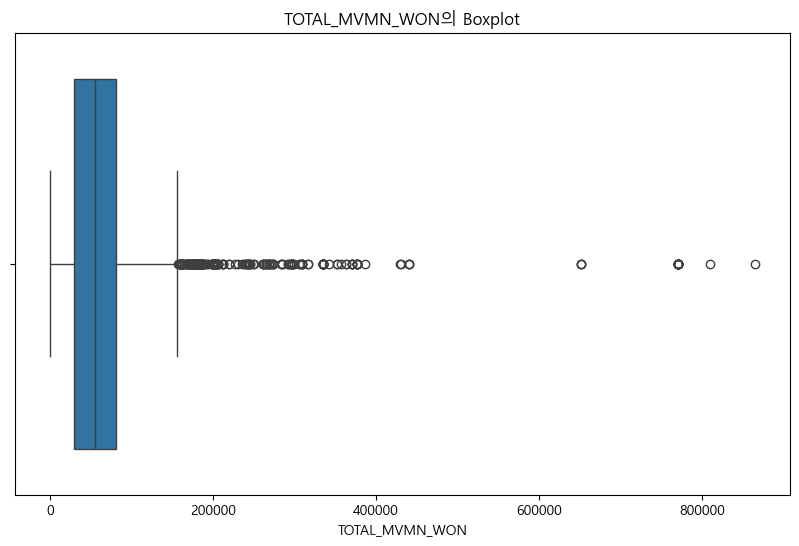

In [2278]:
# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=travel_log, x='TOTAL_MVMN_WON')
plt.title('TOTAL_MVMN_WON의 Boxplot')
plt.xlabel('TOTAL_MVMN_WON')
plt.show()

> BOXPLOT의 이상치 기준인 1.5IQR을 넘어서는 수치는 많지만, 해당 수치들은 대부분 모여 있으며 분석에 필요한 데이터들이므로, 600000 이상의 데이터만 제거하기로 결정함

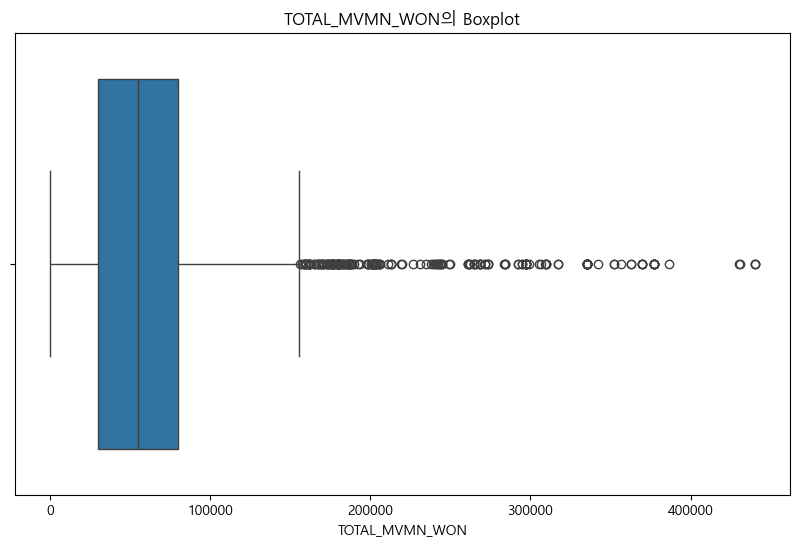

In [2279]:
# 'TOTAL_MVMN_WON' 값이 600,000을 넘는 행을 제거
travel_log = travel_log[travel_log['TOTAL_MVMN_WON'] <= 600000]

# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=travel_log, x='TOTAL_MVMN_WON')
plt.title('TOTAL_MVMN_WON의 Boxplot')
plt.xlabel('TOTAL_MVMN_WON')
plt.show()


<2> TOTAL_ACTIVITY_WON

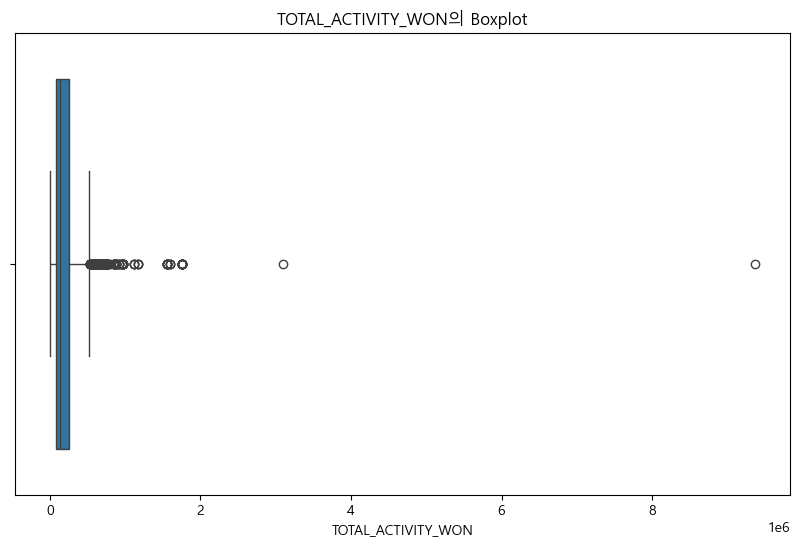

In [2280]:
# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=travel_log, x='TOTAL_ACTIVITY_WON')
plt.title('TOTAL_ACTIVITY_WON의 Boxplot')
plt.xlabel('TOTAL_ACTIVITY_WON')
plt.show()

> BOXPLOT의 이상치 기준인 1.5IQR을 넘어서는 수치는 많지만, 해당 수치들은 대부분 모여 있으며 분석에 필요한 데이터들이므로, 현재 x축 단위인 1e6 기준으로 1.5 이상의 데이터만 제거하기로 결정함

C:\Users\kimbomi\AppData\Local\Temp\ipykernel_15140\469682411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_log['TOTAL_ACTIVITY_WON'] = travel_log['TOTAL_ACTIVITY_WON'] / 1e6


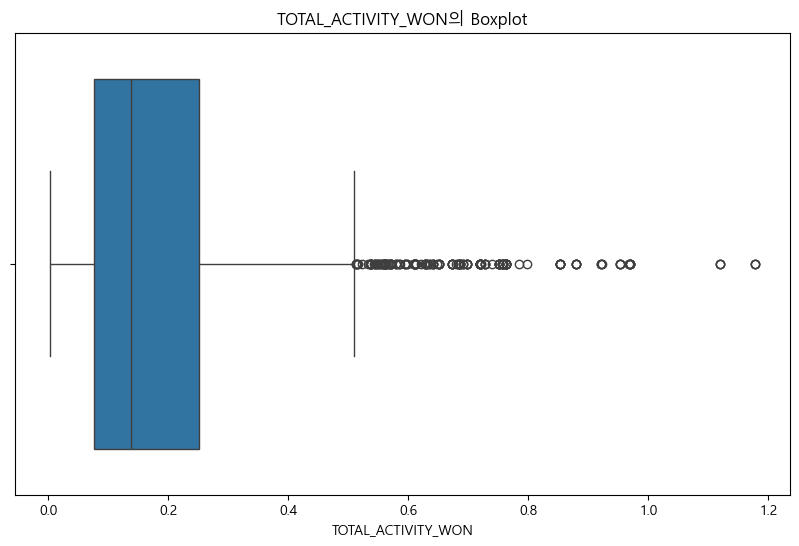

In [2281]:
# 'TOTAL_ACTIVITY_WON' 값을 1,000,000으로 나누어 백만 단위로 변환
travel_log['TOTAL_ACTIVITY_WON'] = travel_log['TOTAL_ACTIVITY_WON'] / 1e6

# 4 이상인 값을 제거
travel_log = travel_log[travel_log['TOTAL_ACTIVITY_WON'] < 1.5]

# Boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=travel_log, x='TOTAL_ACTIVITY_WON')
plt.title('TOTAL_ACTIVITY_WON의 Boxplot')
plt.xlabel('TOTAL_ACTIVITY_WON')
plt.show()


2. 결측치 처리 - 동반자정보 관련 변수인 REL_CD, COMPANION_GENDER, COMPANION_AGE_GRP 발생 이유 분석 위해 '나홀로 여행'인지 검증

In [2282]:
# REL_CD가 결측치이고, TRAVEL_STATUS_ACCOMPANY가 '나홀로 여행'인 데이터 필터링
missing_rel_cd_and_solotravel = travel_log[(travel_log['REL_CD'].isnull()) & (travel_log['TRAVEL_STATUS_ACCOMPANY'] == '나홀로 여행')]

# 해당 데이터의 개수
count = missing_rel_cd_and_solotravel.shape[0]

print(f"REL_CD가 결측치이고, TRAVEL_STATUS_ACCOMPANY가 '나홀로 여행'인 데이터의 개수: {count}")

REL_CD가 결측치이고, TRAVEL_STATUS_ACCOMPANY가 '나홀로 여행'인 데이터의 개수: 452


In [2283]:
# REL_CD가 결측치이고, TRAVEL_STATUS_ACCOMPANY가 '나홀로 여행'이 아닌 데이터 필터링
filtered_data = travel_log[travel_log['REL_CD'].isnull() & (travel_log['TRAVEL_STATUS_ACCOMPANY'] != '나홀로 여행')]

# 결과 출력
print(filtered_data)

     GENDER  AGE_GRP        JOB_NM TRAVEL_TERM  TRAVEL_LIKE_SGG_1  TRAVEL_LIKE_SGG_2  TRAVEL_LIKE_SGG_3 TRAVEL_STYL_1 TRAVEL_STYL_2 TRAVEL_STYL_3 TRAVEL_STYL_4 TRAVEL_STYL_5 TRAVEL_STYL_6 TRAVEL_STYL_7 TRAVEL_STYL_8 TRAVEL_STATUS_RESIDENCE TRAVEL_STATUS_DESTINATION TRAVEL_STATUS_ACCOMPANY               TRAVEL_MOTIVE  TRAVEL_COMPANIONS_NUM  TRAVEL_ID REL_CD COMPANION_GENDER COMPANION_AGE_GRP                               TRAVEL_PURPOSE TRAVEL_START_YMD TRAVEL_END_YMD                       TRAVEL_MISSION_CHECK     MAJOR_TRANSPORT  TOTAL_MVMN_WON    MAJOR_ACTIVITY_TYPE  TOTAL_ACTIVITY_WON
1621      여       30  전문가 및 관련 종사자          1년              26200              46130              42150            중립            중립      도시 선호(중)      도시 선호(중)            중립      자연 선호(약)      도시 선호(중)      자연 선호(강)                    전라북도                        전남                자녀 동반 여행  일상적인 환경 및 역할에서의 탈출, 지루함 탈피                      2  g_g009362    NaN              NaN               NaN     SNS 인생샷 여

In [2284]:
# '나홀로 여행'인 경우 동반자 정보 결측치를 처리
travel_log.loc[
    (travel_log['REL_CD'].isnull()) & (travel_log['TRAVEL_STATUS_ACCOMPANY'] == '나홀로 여행'), 
    ['REL_CD', 'COMPANION_GENDER', 'COMPANION_AGE_GRP']
] = ['없음', '없음', '없음']

# '나홀로 여행'이 아닌 경우 해당 행 삭제
travel_log = travel_log.drop(
    travel_log[(travel_log['REL_CD'].isnull()) & (travel_log['TRAVEL_STATUS_ACCOMPANY'] != '나홀로 여행')].index
)

# 결과 확인
null_status = travel_log[['REL_CD', 'COMPANION_GENDER', 'COMPANION_AGE_GRP']].isnull().sum()
print(null_status)

REL_CD               0
COMPANION_GENDER     0
COMPANION_AGE_GRP    0
dtype: int64


3. 결측치 처리 - MAJOR_TRANSPORT의 결측치는 없음으로, TOTAL_MVMN_WON의 결측치는 현재 TOTAL_MVMN_WON의 평균값으로 대체

In [2285]:
# MAJOR_TRANSPORT 결측치 처리
travel_log['MAJOR_TRANSPORT'].fillna('없음', inplace=True)

# TOTAL_MVMN_WON 결측치 처리
mean_total_mvmn_won = travel_log['TOTAL_MVMN_WON'].mean()
travel_log['TOTAL_MVMN_WON'].fillna(mean_total_mvmn_won, inplace=True)

# 결측치 처리 후 데이터 상태 확인
null_status = travel_log[['MAJOR_TRANSPORT', 'TOTAL_MVMN_WON']].isnull().sum()
print(null_status)

MAJOR_TRANSPORT    0
TOTAL_MVMN_WON     0
dtype: int64


4. 결측치 처리 - TOTAL_ACTIVITY_WON의 결측치를 현재 TOTAL_ACTIVITY_WON의 평균값으로 대체

In [2286]:
# TOTAL_ACTIVITY_WON 결측치의 평균값 계산
mean_total_activity_won = travel_log['TOTAL_ACTIVITY_WON'].mean()

# 결측치를 평균값으로 대체
travel_log['TOTAL_ACTIVITY_WON'].fillna(mean_total_activity_won, inplace=True)

# 결측치 처리 후 데이터 상태 확인
null_status_activity = travel_log['TOTAL_ACTIVITY_WON'].isnull().sum()
print(null_status_activity)

0


5. 이후 추가 분석시 사용하기 위해 이동수단총소비액과 활동총소비액을 합친 총소비액 파생변수 추가

In [2287]:
# TOTAL_WON 파생변수 추가
travel_log['TOTAL_WON'] = travel_log['TOTAL_MVMN_WON'] + travel_log['TOTAL_ACTIVITY_WON']

# 결과 확인
print(travel_log[['TOTAL_MVMN_WON', 'TOTAL_ACTIVITY_WON', 'TOTAL_WON']].head())

   TOTAL_MVMN_WON  TOTAL_ACTIVITY_WON  TOTAL_WON
0       10,000.00                0.07  10,000.07
1       32,600.00                0.27  32,600.27
2      138,400.00                0.45 138,400.45
3       70,000.00                0.12  70,000.12
4       52,083.00                0.12  52,083.12


6. 이후 추가 분석시 사용하기 위해 여행 기간 파생변수 추가

In [2288]:
# 날짜 변환
travel_log['TRAVEL_START_YMD'] = pd.to_datetime(travel_log['TRAVEL_START_YMD'])
travel_log['TRAVEL_END_YMD'] = pd.to_datetime(travel_log['TRAVEL_END_YMD'])

# 여행 기간 계산
travel_log['TRAVEL_DURATION'] = (travel_log['TRAVEL_END_YMD'] - travel_log['TRAVEL_START_YMD']).dt.days

# 결과 확인
print(travel_log[['TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_DURATION']].head(50))

   TRAVEL_START_YMD TRAVEL_END_YMD  TRAVEL_DURATION
0        2023-06-14     2023-06-16                2
1        2023-07-28     2023-07-30                2
2        2023-09-07     2023-09-10                3
3        2023-07-01     2023-07-03                2
4        2023-07-18     2023-07-20                2
5        2023-08-30     2023-08-31                1
6        2023-08-30     2023-08-31                1
7        2023-08-30     2023-08-31                1
8        2023-08-30     2023-08-31                1
9        2023-06-04     2023-06-07                3
10       2023-06-04     2023-06-07                3
11       2023-06-04     2023-06-07                3
12       2023-08-19     2023-08-20                1
13       2023-08-19     2023-08-20                1
14       2023-08-19     2023-08-20                1
15       2023-08-20     2023-08-22                2
16       2023-09-28     2023-09-29                1
17       2023-06-16     2023-06-18                2
18       202

7. 이후 추가 분석시 사용하기 위해 여행 계절 파생변수 추가

In [2289]:
# 계절별 분류 함수 정의
def categorize_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

# 'TRAVEL_START_YMD'에서 월을 추출하여 계절 분류
travel_log['SEASON'] = travel_log['TRAVEL_START_YMD'].dt.month.apply(categorize_season)

# 결과 확인
print(travel_log[['TRAVEL_START_YMD', 'TRAVEL_END_YMD', 'TRAVEL_DURATION', 'SEASON']].head(50))

   TRAVEL_START_YMD TRAVEL_END_YMD  TRAVEL_DURATION  SEASON
0        2023-06-14     2023-06-16                2  Summer
1        2023-07-28     2023-07-30                2  Summer
2        2023-09-07     2023-09-10                3  Autumn
3        2023-07-01     2023-07-03                2  Summer
4        2023-07-18     2023-07-20                2  Summer
5        2023-08-30     2023-08-31                1  Summer
6        2023-08-30     2023-08-31                1  Summer
7        2023-08-30     2023-08-31                1  Summer
8        2023-08-30     2023-08-31                1  Summer
9        2023-06-04     2023-06-07                3  Summer
10       2023-06-04     2023-06-07                3  Summer
11       2023-06-04     2023-06-07                3  Summer
12       2023-08-19     2023-08-20                1  Summer
13       2023-08-19     2023-08-20                1  Summer
14       2023-08-19     2023-08-20                1  Summer
15       2023-08-20     2023-08-22      

<h3>3. 전처리 후 확인</h3>

In [2290]:
# 데이터의 행, 열 개수 출력
print('merge 데이터의 행, 열 개수 : ')
print(travel_log.shape)

merge 데이터의 행, 열 개수 : 
(3877, 35)


In [2291]:
# 데이터의 구조와 타입 확인
print('merge 데이터의 구조와 타입 : ')
print(travel_log.info())

merge 데이터의 구조와 타입 : 
<class 'pandas.core.frame.DataFrame'>
Index: 3877 entries, 0 to 4293
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   GENDER                     3877 non-null   object        
 1   AGE_GRP                    3877 non-null   int64         
 2   JOB_NM                     3877 non-null   object        
 3   TRAVEL_TERM                3877 non-null   object        
 4   TRAVEL_LIKE_SGG_1          3877 non-null   int64         
 5   TRAVEL_LIKE_SGG_2          3877 non-null   int64         
 6   TRAVEL_LIKE_SGG_3          3877 non-null   int64         
 7   TRAVEL_STYL_1              3877 non-null   object        
 8   TRAVEL_STYL_2              3877 non-null   object        
 9   TRAVEL_STYL_3              3877 non-null   object        
 10  TRAVEL_STYL_4              3877 non-null   object        
 11  TRAVEL_STYL_5              3877 non-null   object    

In [2292]:
# 데이터의 결측치 확인
print('merge 데이터.csv의 결측치 : ')
print(travel_log.isnull().sum())

merge 데이터.csv의 결측치 : 
GENDER                       0
AGE_GRP                      0
JOB_NM                       0
TRAVEL_TERM                  0
TRAVEL_LIKE_SGG_1            0
TRAVEL_LIKE_SGG_2            0
TRAVEL_LIKE_SGG_3            0
TRAVEL_STYL_1                0
TRAVEL_STYL_2                0
TRAVEL_STYL_3                0
TRAVEL_STYL_4                0
TRAVEL_STYL_5                0
TRAVEL_STYL_6                0
TRAVEL_STYL_7                0
TRAVEL_STYL_8                0
TRAVEL_STATUS_RESIDENCE      0
TRAVEL_STATUS_DESTINATION    0
TRAVEL_STATUS_ACCOMPANY      0
TRAVEL_MOTIVE                0
TRAVEL_COMPANIONS_NUM        0
TRAVEL_ID                    0
REL_CD                       0
COMPANION_GENDER             0
COMPANION_AGE_GRP            0
TRAVEL_PURPOSE               0
TRAVEL_START_YMD             0
TRAVEL_END_YMD               0
TRAVEL_MISSION_CHECK         0
MAJOR_TRANSPORT              0
TOTAL_MVMN_WON               0
MAJOR_ACTIVITY_TYPE          0
TOTAL_ACTIVITY_WO

<h3>4. 병합 CSV 저장</h3>

In [2293]:
travel_log.to_csv('data/training/merged_data/merge.csv',index=False)